In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, lr=0.001, weight_decay=None):
        super().__init__()
        # Initialize layers separately for better control
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.output = nn.Linear(hidden_size2, output_size)
        
        if weight_decay:
            # Use Adam optimizer with L2 regularization
            # self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
            self.optimizer = optim.SGD(self.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            # Use Adam optimizer without regularization
            # self.optimizer = optim.Adam(self.parameters(), lr=lr)
            self.optimizer = optim.SGD(self.parameters(), lr=lr)
        self.loss_criteria = nn.MSELoss()

    def forward(self, x):
        # Sigmoid activation for hidden layers, but no activation for output
        x = torch.sigmoid(self.hidden1(x.to(torch.float32)))
        x = torch.sigmoid(self.hidden2(x))
        x = self.output(x)  # Linear output layer
        return x

In [3]:
def mackey_glass(n_points, tau, dt=0.1):
    """Generate Mackey-Glass time series with proper initialization.
    
    Args:
        n_points: Number of points to generate
        tau: Time delay
        dt: Time step for numerical integration (smaller dt = more accurate)
    """
    beta = 0.2
    gamma = 0.1
    n = 10
    
    # Convert tau to number of time steps
    tau_steps = int(tau/dt)
    
    # Generate more points to account for numerical integration
    total_points = int(n_points/dt)
    x = np.zeros(total_points)
    
    # Initialize with a constant value > 0
    x[0:tau_steps] = 1.5
    
    # Use numerical integration with small time steps
    for t in range(tau_steps, total_points-1):
        dx = (beta * x[t-tau_steps]/(1 + x[t-tau_steps]**n) - gamma * x[t]) * dt
        x[t+1] = x[t] + dx
    
    # Downsample to get requested number of points
    return x[::int(1/dt)][:n_points]

In [4]:
input_data = mackey_glass(1505, 25)

In [5]:
print(f'Input data: {input_data.shape}')

Input data: (1505,)


In [6]:
def prepare_data(series, start, end, noise=False, sigma=0.005):
    inputs = []
    targets = []
    for t in range(start, end):
        if noise:
            input_noise = np.random.normal(0, sigma, 5)
            target_noise = np.random.normal(0, sigma, 1)[0]
            inputs.append([
                series[t - 20] + input_noise[0],
                series[t - 15] + input_noise[1],
                series[t - 10] + input_noise[2],
                series[t - 5] + input_noise[3],
                series[t] + input_noise[4]
            ])
            targets.append(series[t + 5] + target_noise)
        else:
            inputs.append([series[t - 20], series[t - 15], series[t - 10], series[t - 5], series[t]])
            targets.append(series[t + 5])

    inputs = np.array(inputs, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32).reshape(-1, 1)
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(inputs).float()
    y = torch.from_numpy(targets).float()
    
    return X, y

In [7]:
def train_model(model, train_X, train_y, val_X, val_y, n_epochs=1000, patience=20):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        model.optimizer.zero_grad()
        
        # Forward pass on full training set
        outputs = model(train_X)
        loss = model.loss_criteria(outputs, train_y)
        
        # Backward pass
        loss.backward()
        model.optimizer.step()
        
        train_loss = loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_X)
            val_loss = model.loss_criteria(val_outputs, val_y).item()
        
        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # # Early stopping
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print(f'Early stopping triggered at epoch {epoch+1}')
        #         break
    
    return train_losses, val_losses



Training model with hidden layers: (3, 2)


/home/emil/anaconda3/envs/appliedEst/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1731532454354/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100/5000, Train Loss: 0.068069, Val Loss: 0.080913
Epoch 200/5000, Train Loss: 0.067665, Val Loss: 0.080448
Epoch 300/5000, Train Loss: 0.067200, Val Loss: 0.079916
Epoch 400/5000, Train Loss: 0.066651, Val Loss: 0.079288
Epoch 500/5000, Train Loss: 0.065987, Val Loss: 0.078530
Epoch 600/5000, Train Loss: 0.065170, Val Loss: 0.077595
Epoch 700/5000, Train Loss: 0.064146, Val Loss: 0.076424
Epoch 800/5000, Train Loss: 0.062847, Val Loss: 0.074939
Epoch 900/5000, Train Loss: 0.061184, Val Loss: 0.073036
Epoch 1000/5000, Train Loss: 0.059043, Val Loss: 0.070585
Epoch 1100/5000, Train Loss: 0.056289, Val Loss: 0.067435
Epoch 1200/5000, Train Loss: 0.052784, Val Loss: 0.063427
Epoch 1300/5000, Train Loss: 0.048434, Val Loss: 0.058458
Epoch 1400/5000, Train Loss: 0.043283, Val Loss: 0.052580
Epoch 1500/5000, Train Loss: 0.037621, Val Loss: 0.046123
Epoch 1600/5000, Train Loss: 0.032013, Val Loss: 0.039722
Epoch 1700/5000, Train Loss: 0.027132, Val Loss: 0.034128
Epoch 1800/5000, Train 

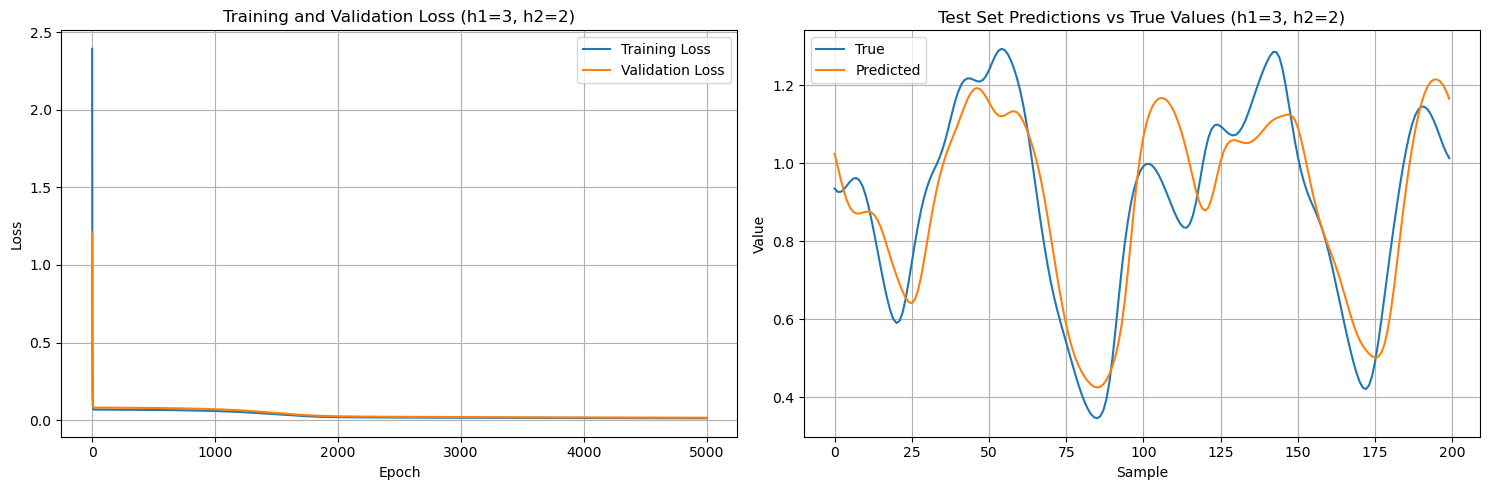


Training model with hidden layers: (3, 4)
Epoch 100/5000, Train Loss: 0.066479, Val Loss: 0.079068
Epoch 200/5000, Train Loss: 0.065746, Val Loss: 0.078243
Epoch 300/5000, Train Loss: 0.064817, Val Loss: 0.077195
Epoch 400/5000, Train Loss: 0.063632, Val Loss: 0.075856
Epoch 500/5000, Train Loss: 0.062112, Val Loss: 0.074139
Epoch 600/5000, Train Loss: 0.060160, Val Loss: 0.071931
Epoch 700/5000, Train Loss: 0.057658, Val Loss: 0.069101
Epoch 800/5000, Train Loss: 0.054482, Val Loss: 0.065510
Epoch 900/5000, Train Loss: 0.050531, Val Loss: 0.061046
Epoch 1000/5000, Train Loss: 0.045797, Val Loss: 0.055705
Epoch 1100/5000, Train Loss: 0.040470, Val Loss: 0.049701
Epoch 1200/5000, Train Loss: 0.035011, Val Loss: 0.043550
Epoch 1300/5000, Train Loss: 0.030069, Val Loss: 0.037970
Epoch 1400/5000, Train Loss: 0.026185, Val Loss: 0.033551
Epoch 1500/5000, Train Loss: 0.023505, Val Loss: 0.030452
Epoch 1600/5000, Train Loss: 0.021805, Val Loss: 0.028430
Epoch 1700/5000, Train Loss: 0.020732,

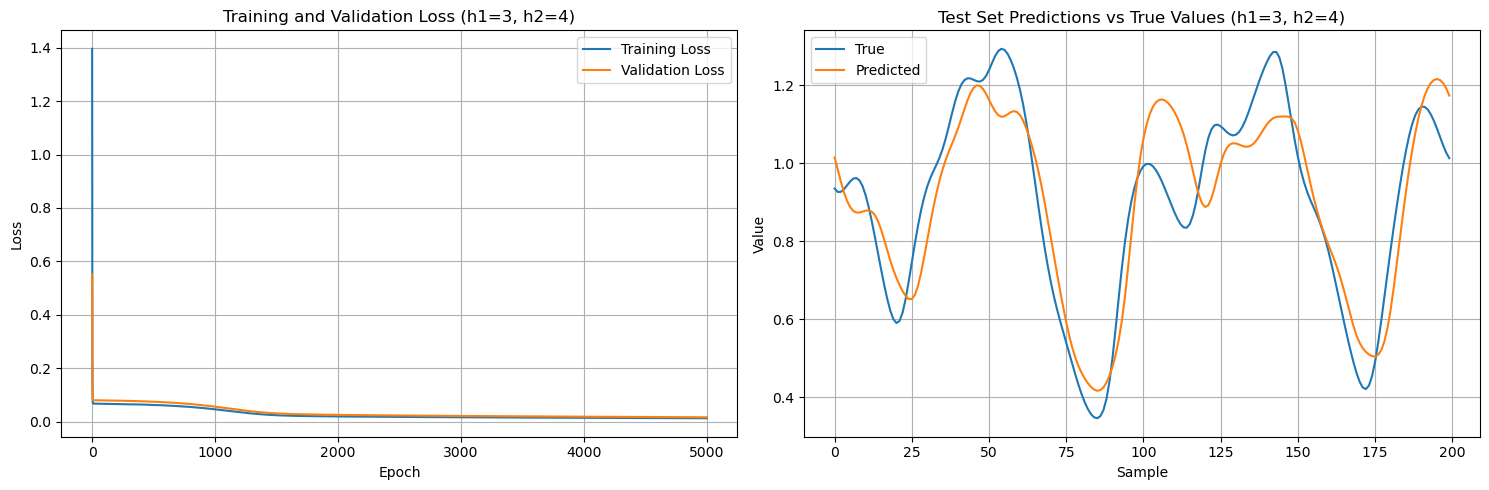


Training model with hidden layers: (3, 6)
Epoch 100/5000, Train Loss: 0.068863, Val Loss: 0.081419
Epoch 200/5000, Train Loss: 0.068702, Val Loss: 0.081242
Epoch 300/5000, Train Loss: 0.068543, Val Loss: 0.081067
Epoch 400/5000, Train Loss: 0.068381, Val Loss: 0.080885
Epoch 500/5000, Train Loss: 0.068210, Val Loss: 0.080693
Epoch 600/5000, Train Loss: 0.068024, Val Loss: 0.080483
Epoch 700/5000, Train Loss: 0.067819, Val Loss: 0.080247
Epoch 800/5000, Train Loss: 0.067585, Val Loss: 0.079978
Epoch 900/5000, Train Loss: 0.067314, Val Loss: 0.079666
Epoch 1000/5000, Train Loss: 0.066995, Val Loss: 0.079297
Epoch 1100/5000, Train Loss: 0.066614, Val Loss: 0.078856
Epoch 1200/5000, Train Loss: 0.066152, Val Loss: 0.078321
Epoch 1300/5000, Train Loss: 0.065586, Val Loss: 0.077665
Epoch 1400/5000, Train Loss: 0.064881, Val Loss: 0.076850
Epoch 1500/5000, Train Loss: 0.063994, Val Loss: 0.075826
Epoch 1600/5000, Train Loss: 0.062867, Val Loss: 0.074526
Epoch 1700/5000, Train Loss: 0.061419,

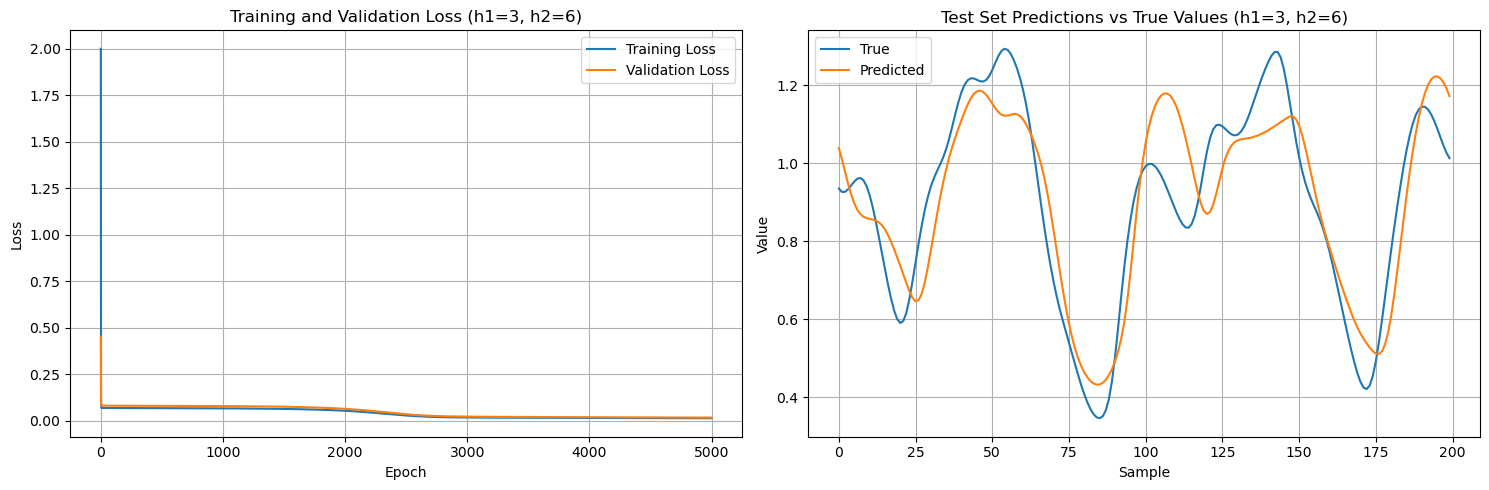


Training model with hidden layers: (4, 2)
Epoch 100/5000, Train Loss: 0.069306, Val Loss: 0.081898
Epoch 200/5000, Train Loss: 0.069007, Val Loss: 0.081554
Epoch 300/5000, Train Loss: 0.068717, Val Loss: 0.081218
Epoch 400/5000, Train Loss: 0.068425, Val Loss: 0.080878
Epoch 500/5000, Train Loss: 0.068123, Val Loss: 0.080525
Epoch 600/5000, Train Loss: 0.067800, Val Loss: 0.080145
Epoch 700/5000, Train Loss: 0.067445, Val Loss: 0.079728
Epoch 800/5000, Train Loss: 0.067047, Val Loss: 0.079258
Epoch 900/5000, Train Loss: 0.066589, Val Loss: 0.078719
Epoch 1000/5000, Train Loss: 0.066055, Val Loss: 0.078089
Epoch 1100/5000, Train Loss: 0.065421, Val Loss: 0.077342
Epoch 1200/5000, Train Loss: 0.064656, Val Loss: 0.076443
Epoch 1300/5000, Train Loss: 0.063720, Val Loss: 0.075345
Epoch 1400/5000, Train Loss: 0.062562, Val Loss: 0.073990
Epoch 1500/5000, Train Loss: 0.061113, Val Loss: 0.072299
Epoch 1600/5000, Train Loss: 0.059281, Val Loss: 0.070168
Epoch 1700/5000, Train Loss: 0.056952,

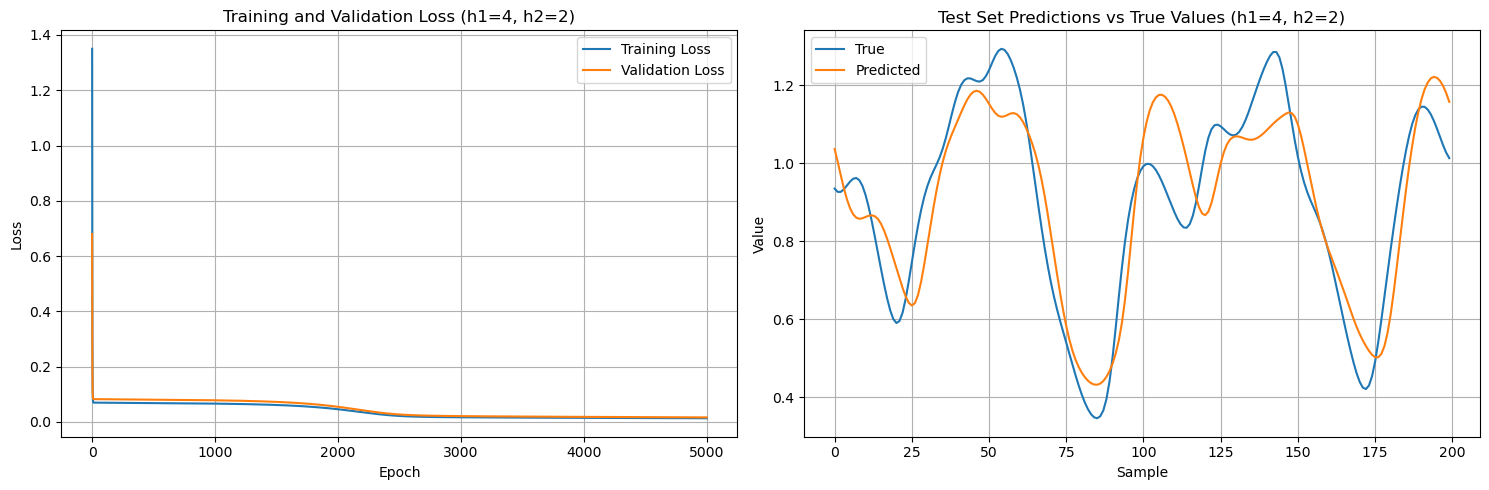


Training model with hidden layers: (4, 4)
Epoch 100/5000, Train Loss: 0.069301, Val Loss: 0.082213
Epoch 200/5000, Train Loss: 0.069016, Val Loss: 0.081904
Epoch 300/5000, Train Loss: 0.068732, Val Loss: 0.081598
Epoch 400/5000, Train Loss: 0.068439, Val Loss: 0.081284
Epoch 500/5000, Train Loss: 0.068127, Val Loss: 0.080950
Epoch 600/5000, Train Loss: 0.067784, Val Loss: 0.080583
Epoch 700/5000, Train Loss: 0.067396, Val Loss: 0.080165
Epoch 800/5000, Train Loss: 0.066944, Val Loss: 0.079678
Epoch 900/5000, Train Loss: 0.066406, Val Loss: 0.079095
Epoch 1000/5000, Train Loss: 0.065753, Val Loss: 0.078383
Epoch 1100/5000, Train Loss: 0.064946, Val Loss: 0.077498
Epoch 1200/5000, Train Loss: 0.063934, Val Loss: 0.076381
Epoch 1300/5000, Train Loss: 0.062648, Val Loss: 0.074951
Epoch 1400/5000, Train Loss: 0.060997, Val Loss: 0.073105
Epoch 1500/5000, Train Loss: 0.058868, Val Loss: 0.070706
Epoch 1600/5000, Train Loss: 0.056125, Val Loss: 0.067595
Epoch 1700/5000, Train Loss: 0.052633,

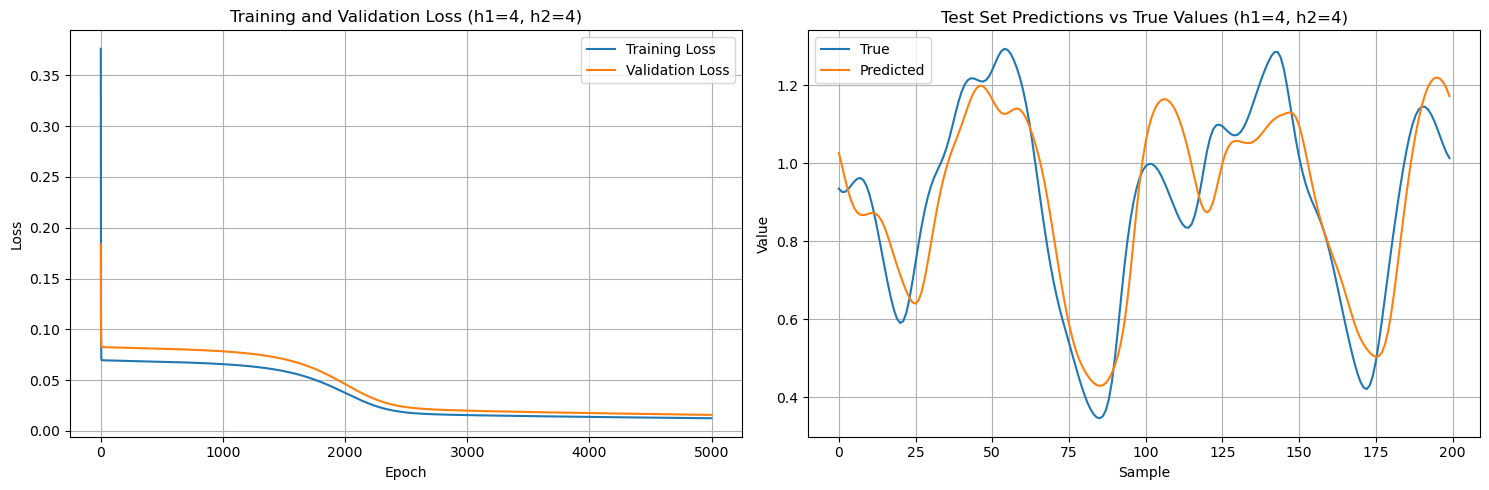


Training model with hidden layers: (4, 6)
Epoch 100/5000, Train Loss: 0.069958, Val Loss: 0.083111
Epoch 200/5000, Train Loss: 0.069540, Val Loss: 0.082623
Epoch 300/5000, Train Loss: 0.069130, Val Loss: 0.082145
Epoch 400/5000, Train Loss: 0.068708, Val Loss: 0.081655
Epoch 500/5000, Train Loss: 0.068253, Val Loss: 0.081128
Epoch 600/5000, Train Loss: 0.067741, Val Loss: 0.080536
Epoch 700/5000, Train Loss: 0.067140, Val Loss: 0.079844
Epoch 800/5000, Train Loss: 0.066413, Val Loss: 0.079006
Epoch 900/5000, Train Loss: 0.065508, Val Loss: 0.077964
Epoch 1000/5000, Train Loss: 0.064355, Val Loss: 0.076636
Epoch 1100/5000, Train Loss: 0.062865, Val Loss: 0.074918
Epoch 1200/5000, Train Loss: 0.060918, Val Loss: 0.072673
Epoch 1300/5000, Train Loss: 0.058373, Val Loss: 0.069737
Epoch 1400/5000, Train Loss: 0.055076, Val Loss: 0.065935
Epoch 1500/5000, Train Loss: 0.050897, Val Loss: 0.061123
Epoch 1600/5000, Train Loss: 0.045804, Val Loss: 0.055277
Epoch 1700/5000, Train Loss: 0.039972,

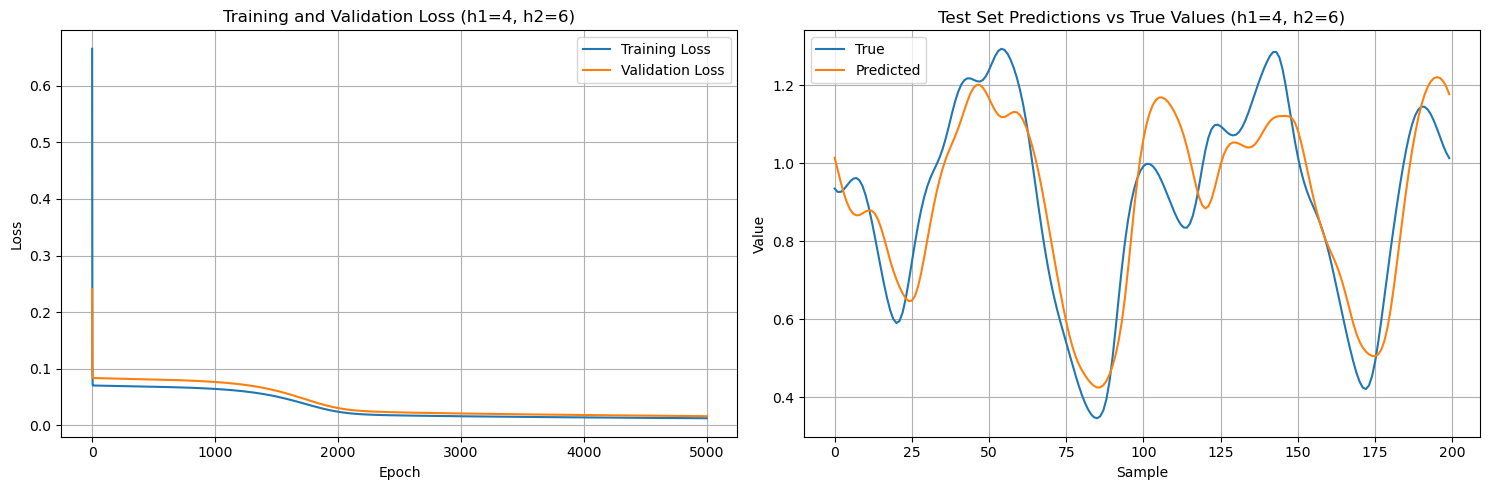


Training model with hidden layers: (5, 2)
Epoch 100/5000, Train Loss: 0.067875, Val Loss: 0.080504
Epoch 200/5000, Train Loss: 0.067664, Val Loss: 0.080258
Epoch 300/5000, Train Loss: 0.067415, Val Loss: 0.079969
Epoch 400/5000, Train Loss: 0.067119, Val Loss: 0.079626
Epoch 500/5000, Train Loss: 0.066763, Val Loss: 0.079212
Epoch 600/5000, Train Loss: 0.066331, Val Loss: 0.078710
Epoch 700/5000, Train Loss: 0.065800, Val Loss: 0.078094
Epoch 800/5000, Train Loss: 0.065141, Val Loss: 0.077331
Epoch 900/5000, Train Loss: 0.064316, Val Loss: 0.076375
Epoch 1000/5000, Train Loss: 0.063270, Val Loss: 0.075166
Epoch 1100/5000, Train Loss: 0.061933, Val Loss: 0.073621
Epoch 1200/5000, Train Loss: 0.060208, Val Loss: 0.071632
Epoch 1300/5000, Train Loss: 0.057971, Val Loss: 0.069058
Epoch 1400/5000, Train Loss: 0.055076, Val Loss: 0.065736
Epoch 1500/5000, Train Loss: 0.051378, Val Loss: 0.061504
Epoch 1600/5000, Train Loss: 0.046800, Val Loss: 0.056279
Epoch 1700/5000, Train Loss: 0.041445,

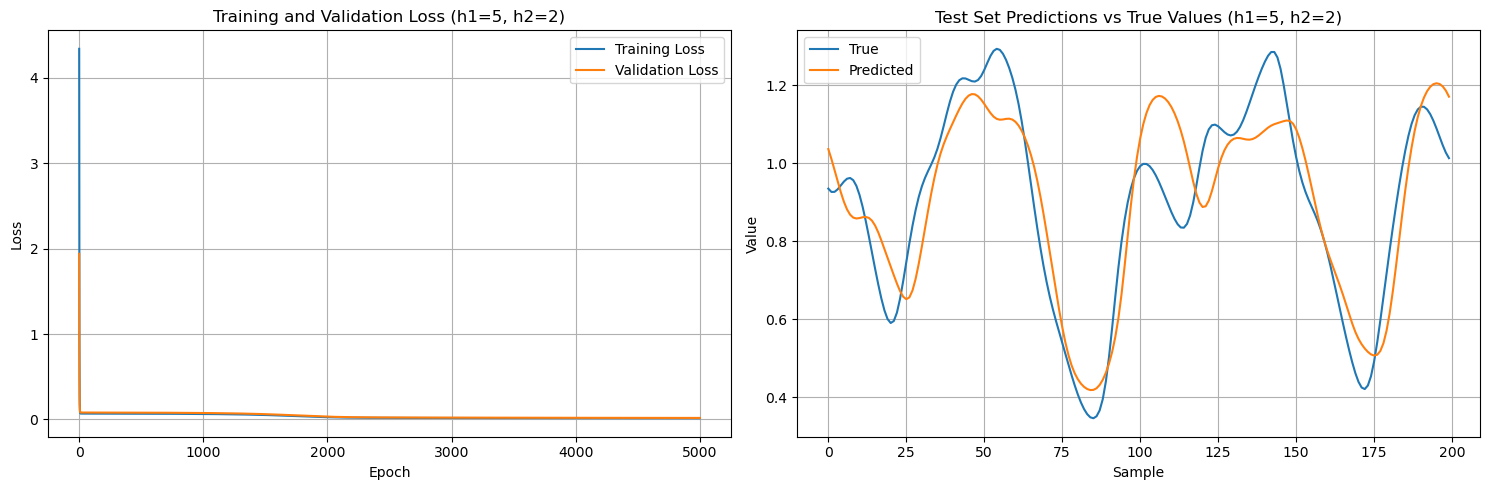


Training model with hidden layers: (5, 4)
Epoch 100/5000, Train Loss: 0.069099, Val Loss: 0.081945
Epoch 200/5000, Train Loss: 0.069064, Val Loss: 0.081901
Epoch 300/5000, Train Loss: 0.069029, Val Loss: 0.081858
Epoch 400/5000, Train Loss: 0.068994, Val Loss: 0.081815
Epoch 500/5000, Train Loss: 0.068958, Val Loss: 0.081771
Epoch 600/5000, Train Loss: 0.068921, Val Loss: 0.081726
Epoch 700/5000, Train Loss: 0.068882, Val Loss: 0.081678
Epoch 800/5000, Train Loss: 0.068841, Val Loss: 0.081628
Epoch 900/5000, Train Loss: 0.068797, Val Loss: 0.081574
Epoch 1000/5000, Train Loss: 0.068749, Val Loss: 0.081516
Epoch 1100/5000, Train Loss: 0.068696, Val Loss: 0.081452
Epoch 1200/5000, Train Loss: 0.068638, Val Loss: 0.081381
Epoch 1300/5000, Train Loss: 0.068573, Val Loss: 0.081302
Epoch 1400/5000, Train Loss: 0.068499, Val Loss: 0.081213
Epoch 1500/5000, Train Loss: 0.068415, Val Loss: 0.081113
Epoch 1600/5000, Train Loss: 0.068319, Val Loss: 0.080998
Epoch 1700/5000, Train Loss: 0.068208,

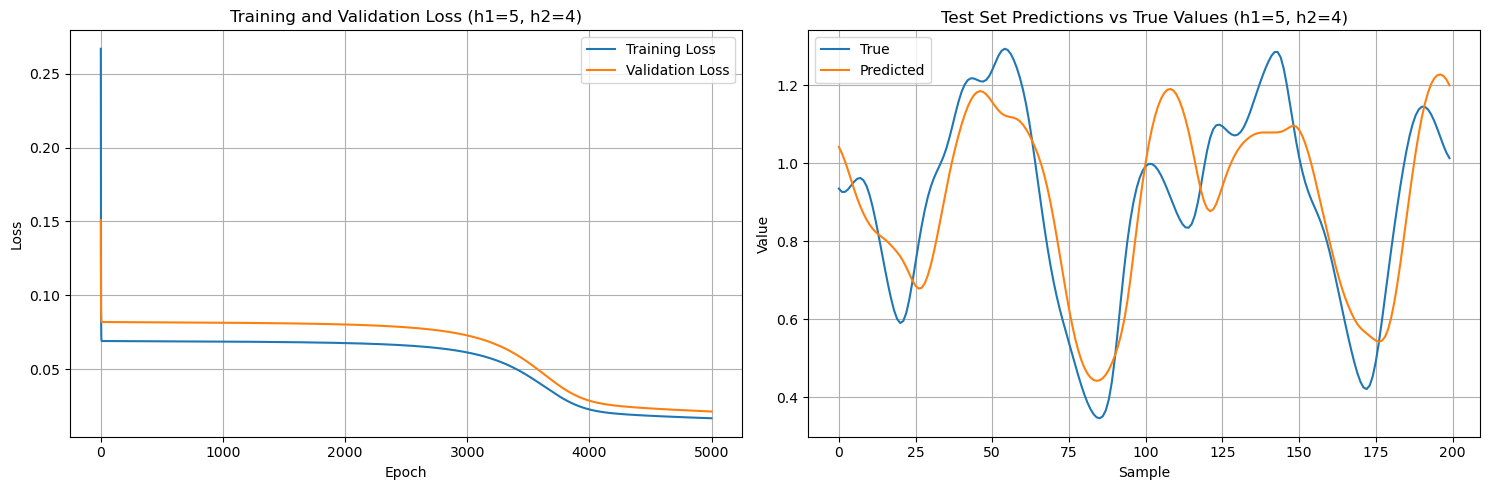


Training model with hidden layers: (5, 6)
Epoch 100/5000, Train Loss: 0.069196, Val Loss: 0.082265
Epoch 200/5000, Train Loss: 0.068702, Val Loss: 0.081693
Epoch 300/5000, Train Loss: 0.068189, Val Loss: 0.081103
Epoch 400/5000, Train Loss: 0.067629, Val Loss: 0.080462
Epoch 500/5000, Train Loss: 0.066994, Val Loss: 0.079737
Epoch 600/5000, Train Loss: 0.066250, Val Loss: 0.078889
Epoch 700/5000, Train Loss: 0.065353, Val Loss: 0.077869
Epoch 800/5000, Train Loss: 0.064248, Val Loss: 0.076614
Epoch 900/5000, Train Loss: 0.062867, Val Loss: 0.075045
Epoch 1000/5000, Train Loss: 0.061120, Val Loss: 0.073061
Epoch 1100/5000, Train Loss: 0.058893, Val Loss: 0.070534
Epoch 1200/5000, Train Loss: 0.056058, Val Loss: 0.067318
Epoch 1300/5000, Train Loss: 0.052487, Val Loss: 0.063269
Epoch 1400/5000, Train Loss: 0.048104, Val Loss: 0.058305
Epoch 1500/5000, Train Loss: 0.042982, Val Loss: 0.052510
Epoch 1600/5000, Train Loss: 0.037453, Val Loss: 0.046260
Epoch 1700/5000, Train Loss: 0.032121,

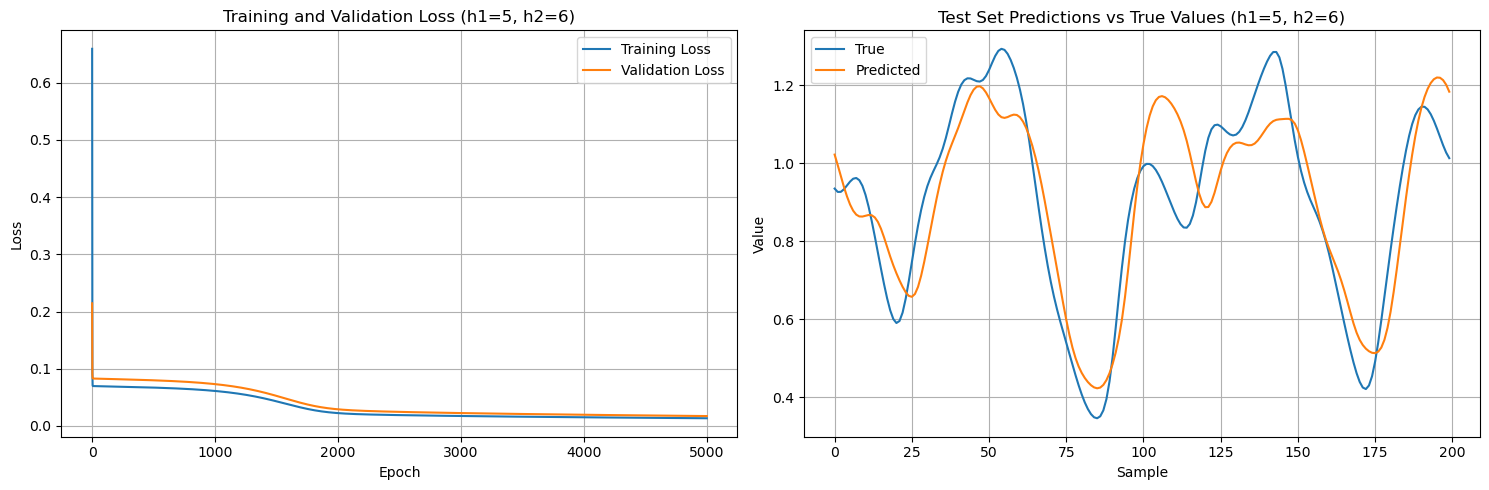

In [8]:
# Generate data using the corrected Mackey-Glass function
input_data = mackey_glass(1505, 25)

# Prepare datasets
train_X, train_y = prepare_data(input_data, 300, 1100, noise=False)
val_X, val_y = prepare_data(input_data, 1100, 1300)
test_X, test_y = prepare_data(input_data, 1300, 1500)

# Grid search over hidden layer sizes
hidden_nodes1 = [3, 4, 5]
hidden_nodes2 = [2, 4, 6]
results = {}

for h1 in hidden_nodes1:
    for h2 in hidden_nodes2:
        print(f"\nTraining model with hidden layers: ({h1}, {h2})")
        model = MLP(
            input_size=5,
            hidden_size1=h1,
            hidden_size2=h2,
            output_size=1,
            lr=0.1
        )
        
        train_losses, val_losses = train_model(
            model,
            train_X,
            train_y,
            val_X,
            val_y,
            n_epochs=5000,
            patience=20
        )
        
        # Generate predictions
        model.eval()
        with torch.no_grad():
            test_pred = model(test_X).numpy()
        
        # Calculate test MSE
        test_mse = np.mean((test_y.numpy() - test_pred) ** 2)
        print(f'Test MSE for h1={h1}, h2={h2}: {test_mse:.6f}')
        
        results[(h1, h2)] = (train_losses, val_losses, test_pred, test_mse)
        
        # Plot results for this configuration
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Training and Validation Loss (h1={h1}, h2={h2})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(test_y.numpy(), label='True')
        plt.plot(test_pred, label='Predicted')
        plt.title(f'Test Set Predictions vs True Values (h1={h1}, h2={h2})')
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Train inputs: torch.Size([800, 5]), Train targets: torch.Size([800, 1])

Training model with hidden layers: (3, 3), weight decay: 0.0001
Epoch 100/5000, Train Loss: 0.072408, Val Loss: 0.081161
Epoch 200/5000, Train Loss: 0.072216, Val Loss: 0.080945
Epoch 300/5000, Train Loss: 0.072005, Val Loss: 0.080706
Epoch 400/5000, Train Loss: 0.071766, Val Loss: 0.080436
Epoch 500/5000, Train Loss: 0.071490, Val Loss: 0.080124
Epoch 600/5000, Train Loss: 0.071166, Val Loss: 0.079757
Epoch 700/5000, Train Loss: 0.070779, Val Loss: 0.079318
Epoch 800/5000, Train Loss: 0.070312, Val Loss: 0.078788
Epoch 900/5000, Train Loss: 0.069742, Val Loss: 0.078140
Epoch 1000/5000, Train Loss: 0.069040, Val Loss: 0.077342
Epoch 1100/5000, Train Loss: 0.068170, Val Loss: 0.076352
Epoch 1200/5000, Train Loss: 0.067087, Val Loss: 0.075118
Epoch 1300/5000, Train Loss: 0.065734, Val Loss: 0.073576
Epoch 1400/5000, Train Loss: 0.064044, Val Loss: 0.071649
Epoch 1500/5000, Train Loss: 0.061941, Val Loss: 0.069251
Ep

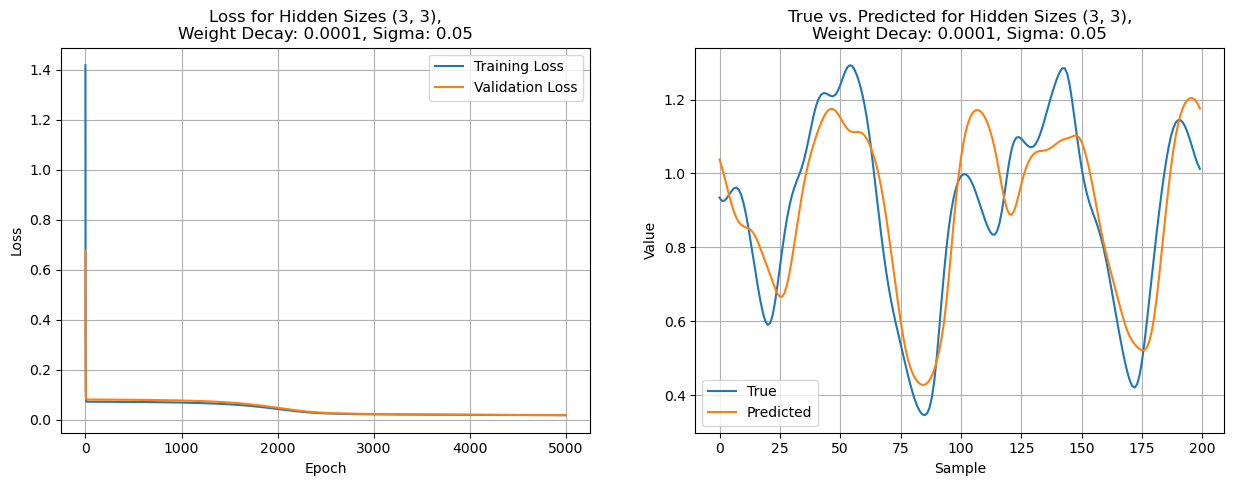

Test MSE for h1=3, h2=3, weight_decay=0.0001: 0.013666


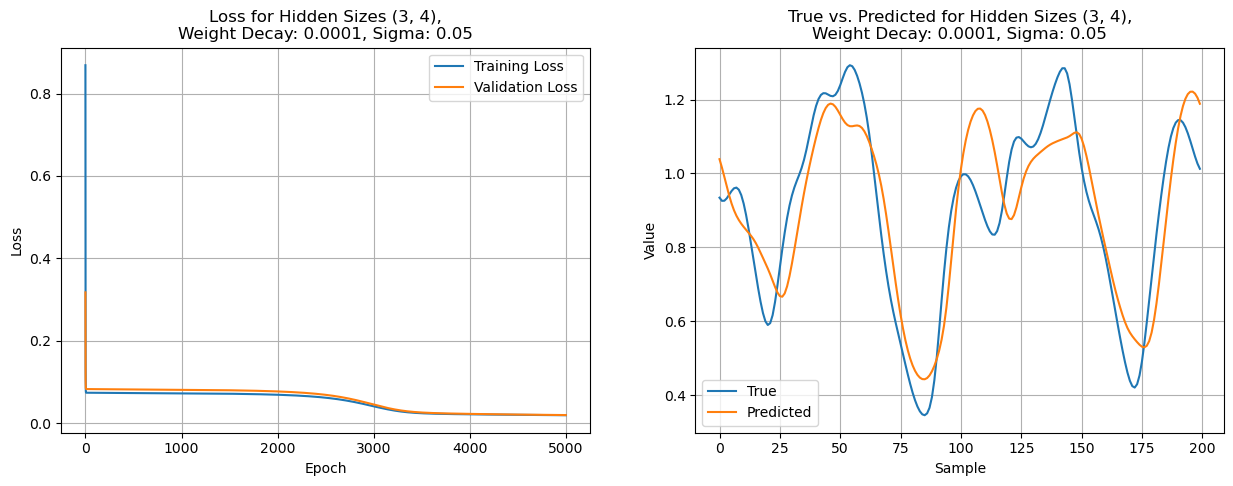

Test MSE for h1=3, h2=4, weight_decay=0.0001: 0.014420


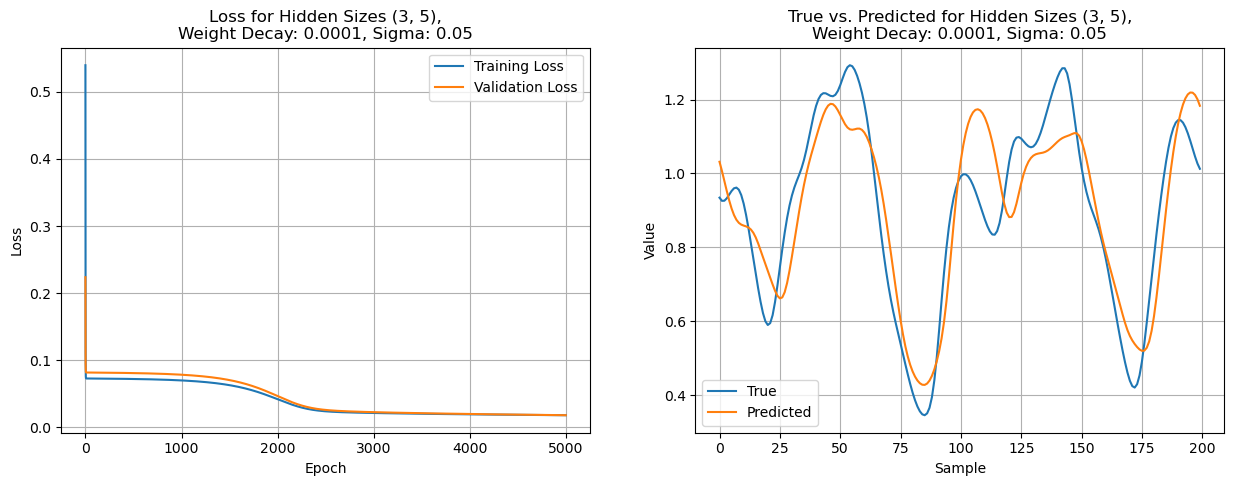

Test MSE for h1=3, h2=5, weight_decay=0.0001: 0.013303


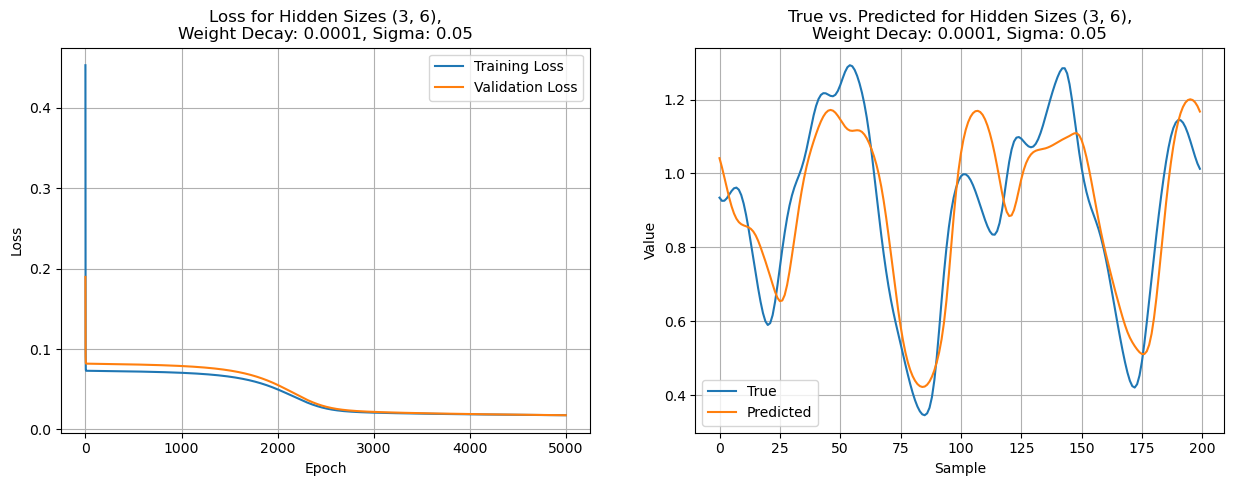

Test MSE for h1=3, h2=6, weight_decay=0.0001: 0.012922


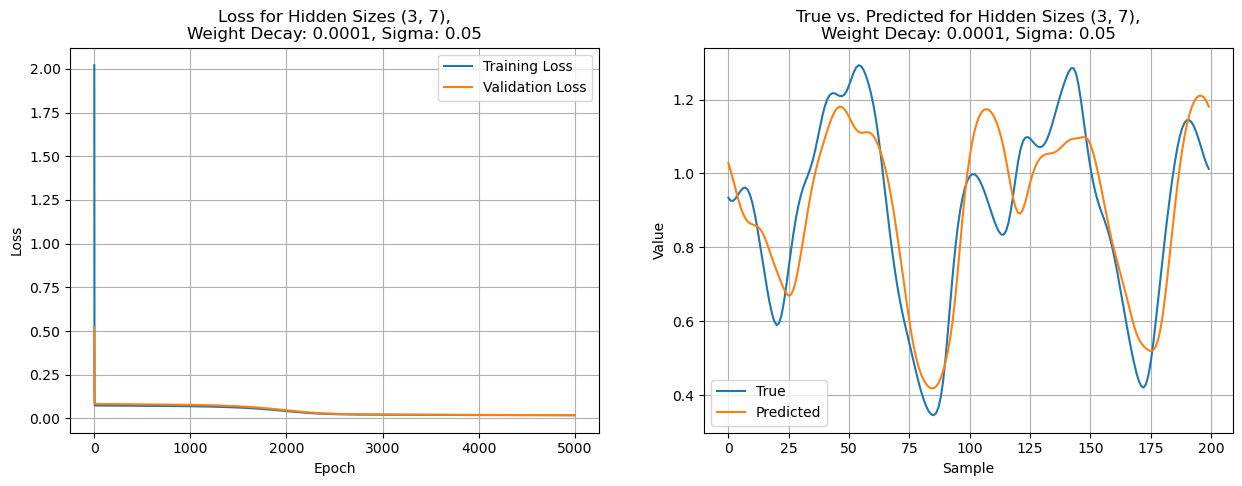

Test MSE for h1=3, h2=7, weight_decay=0.0001: 0.013163


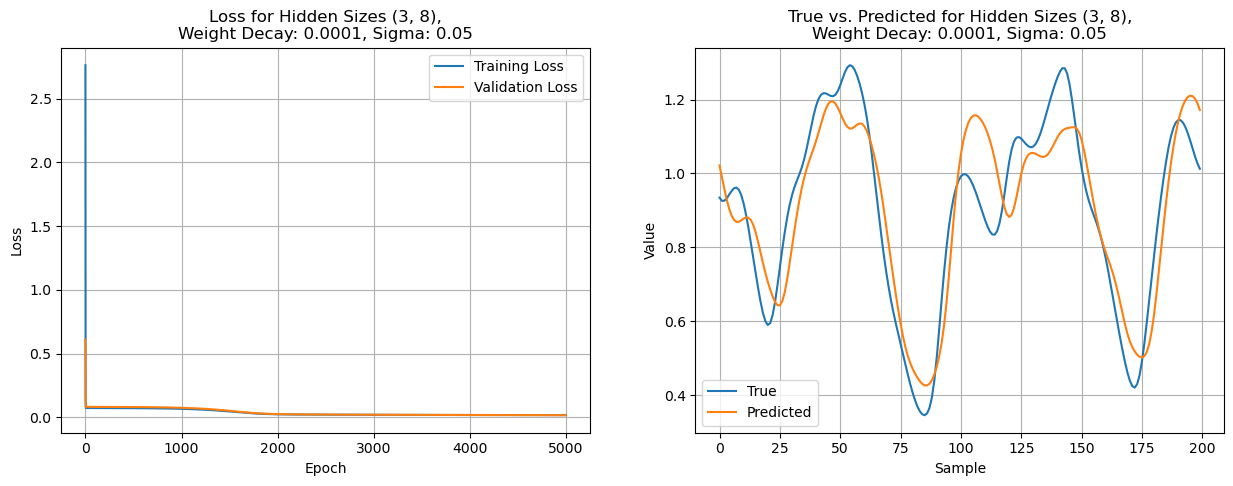

Test MSE for h1=3, h2=8, weight_decay=0.0001: 0.011670


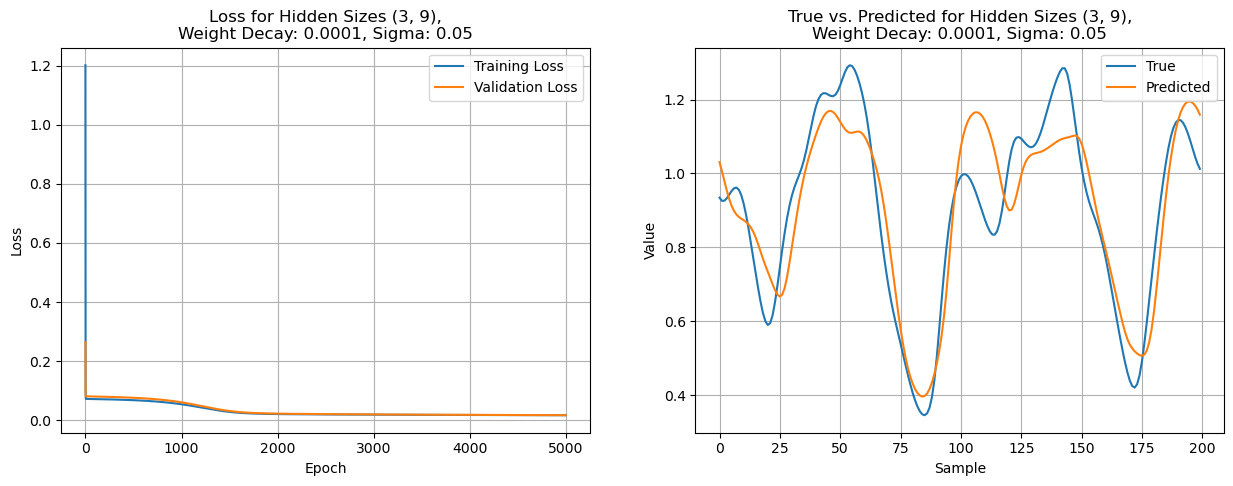

Test MSE for h1=3, h2=9, weight_decay=0.0001: 0.011677


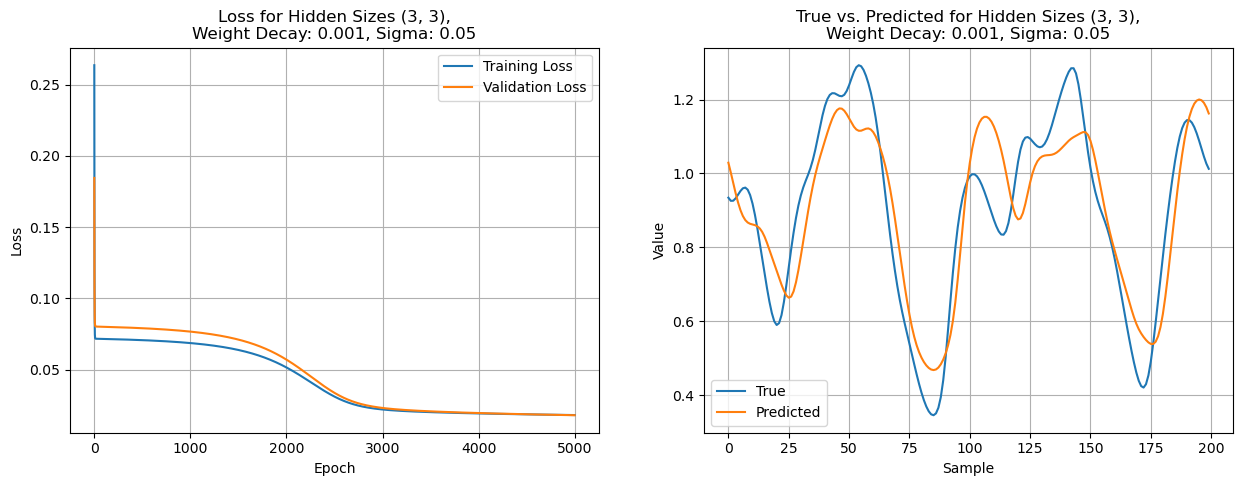

Test MSE for h1=3, h2=3, weight_decay=0.001: 0.013324


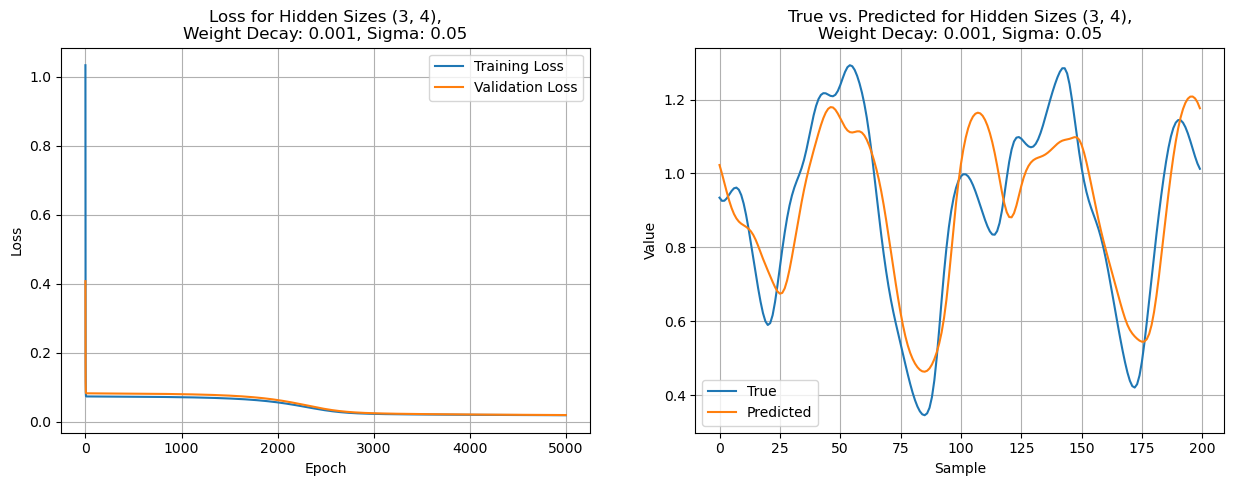

Test MSE for h1=3, h2=4, weight_decay=0.001: 0.013940


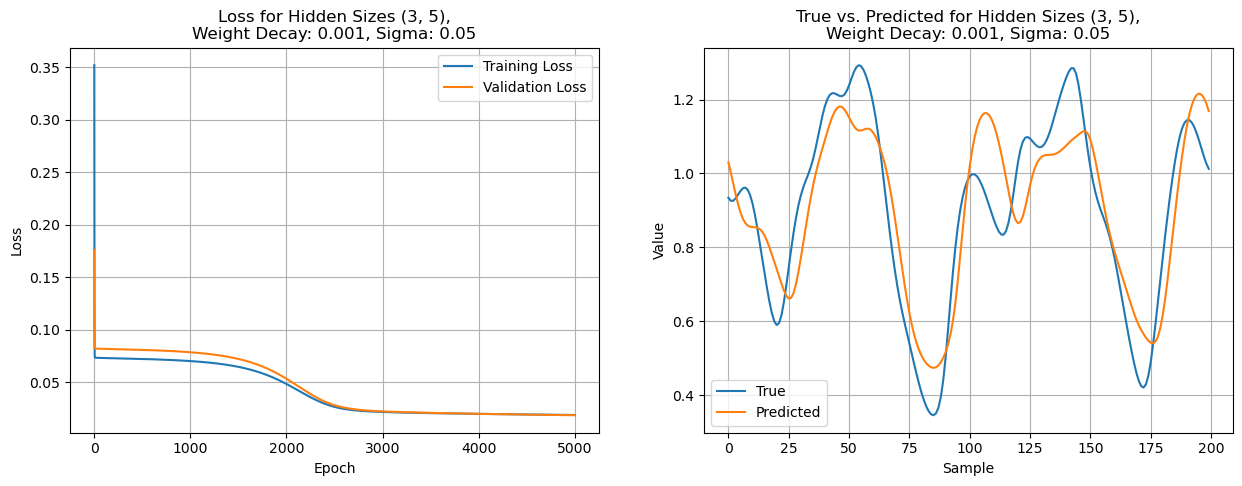

Test MSE for h1=3, h2=5, weight_decay=0.001: 0.014051


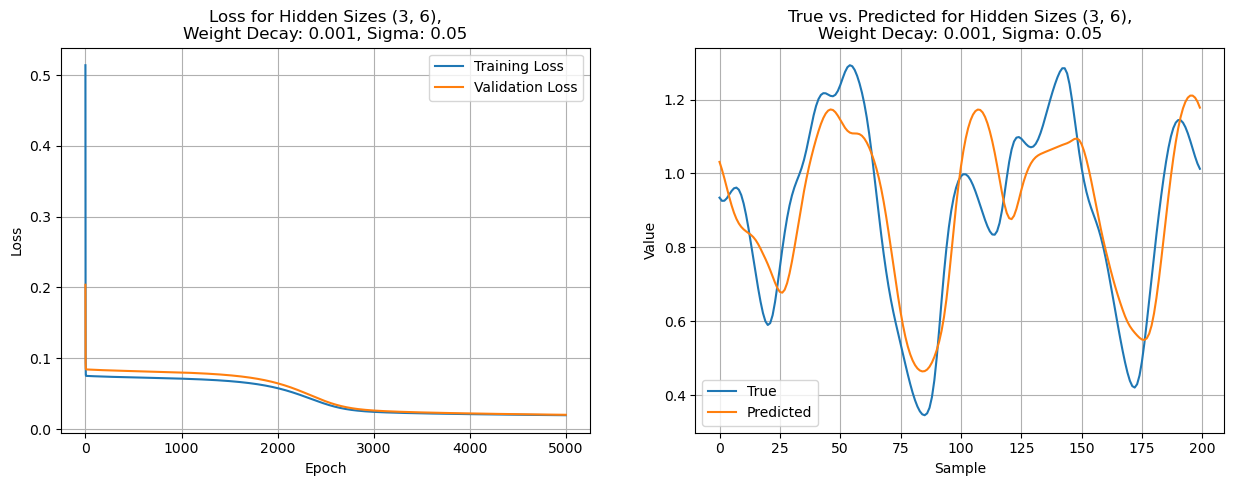

Test MSE for h1=3, h2=6, weight_decay=0.001: 0.014939


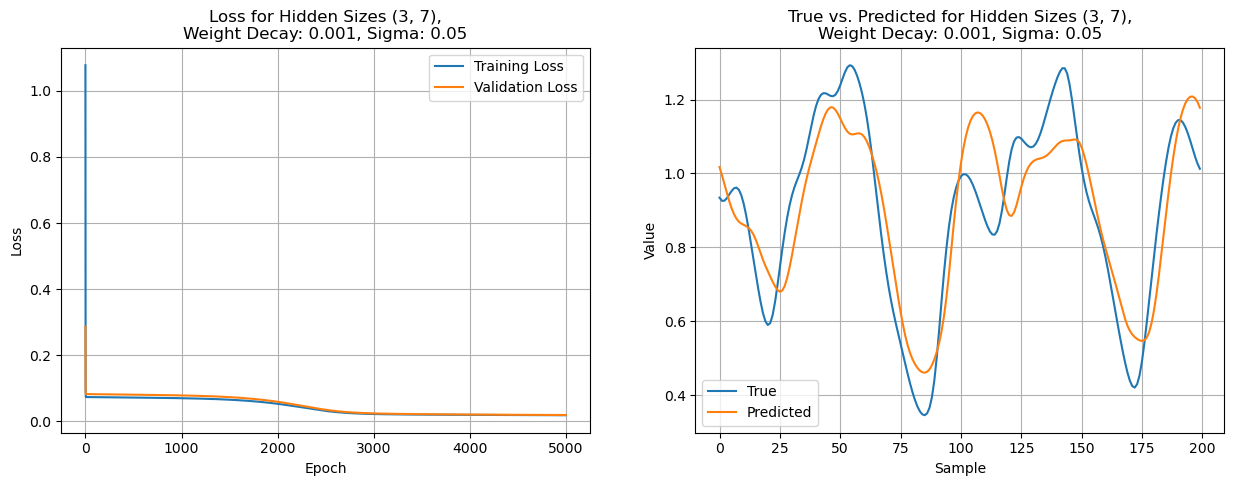

Test MSE for h1=3, h2=7, weight_decay=0.001: 0.013976


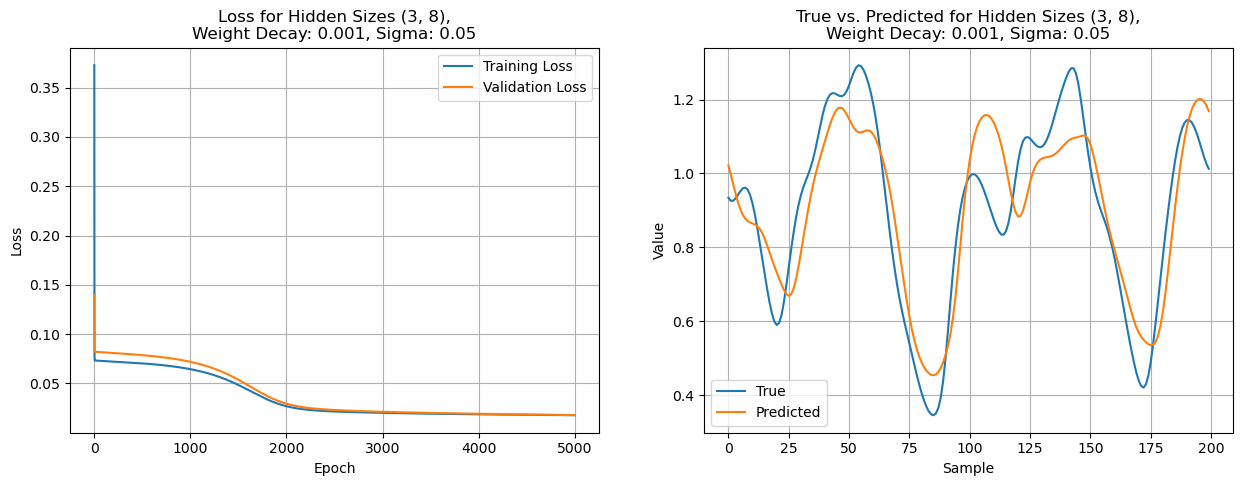

Test MSE for h1=3, h2=8, weight_decay=0.001: 0.013013


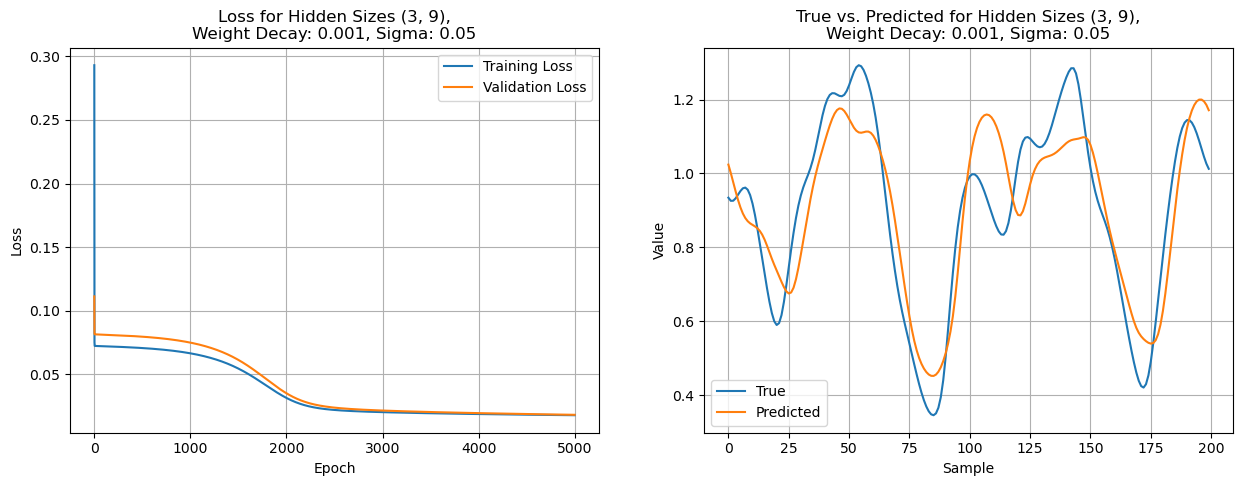

Test MSE for h1=3, h2=9, weight_decay=0.001: 0.013236


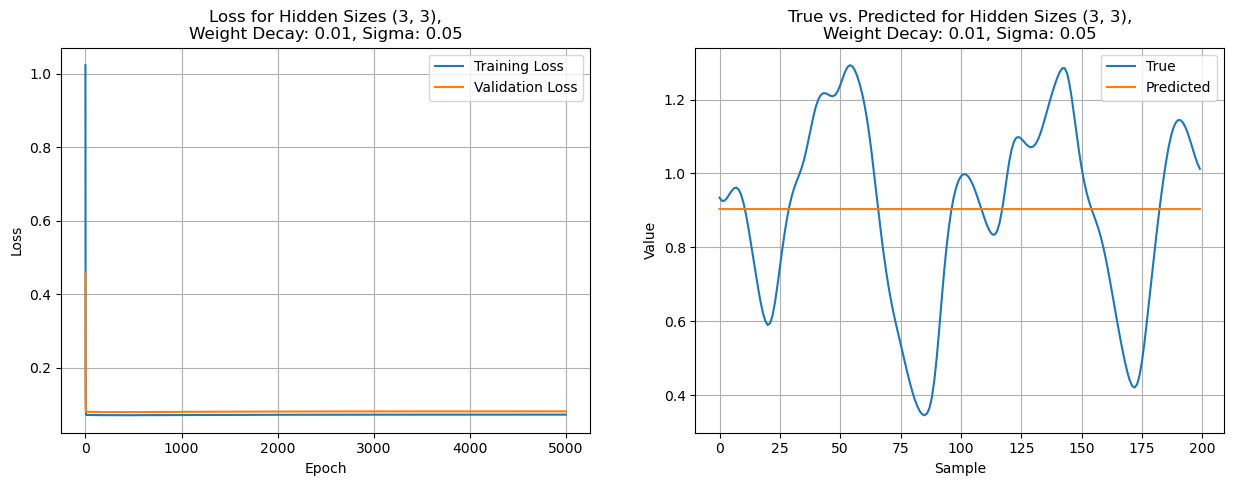

Test MSE for h1=3, h2=3, weight_decay=0.01: 0.065917


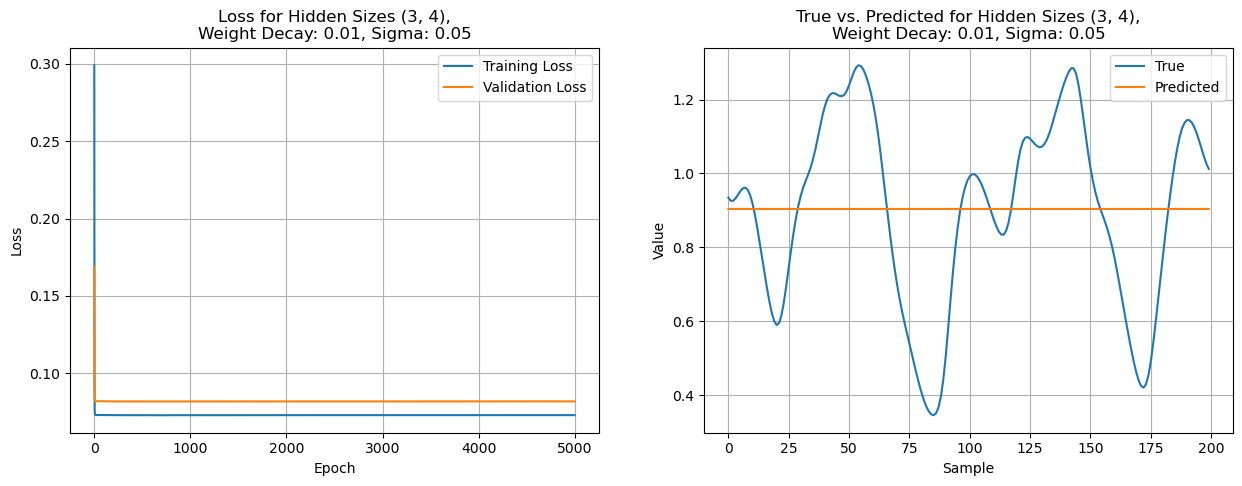

Test MSE for h1=3, h2=4, weight_decay=0.01: 0.065925


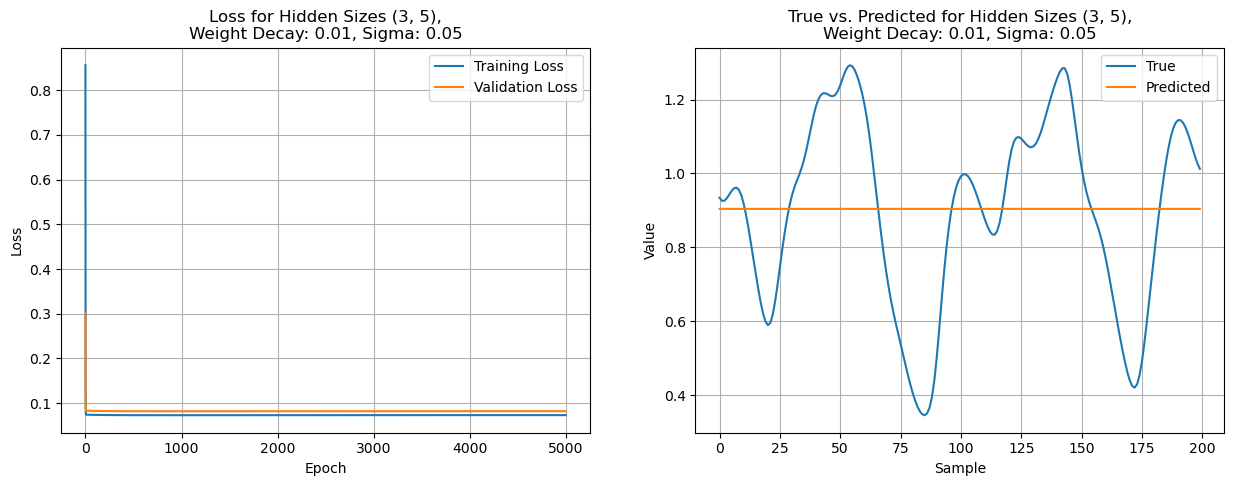

Test MSE for h1=3, h2=5, weight_decay=0.01: 0.065925


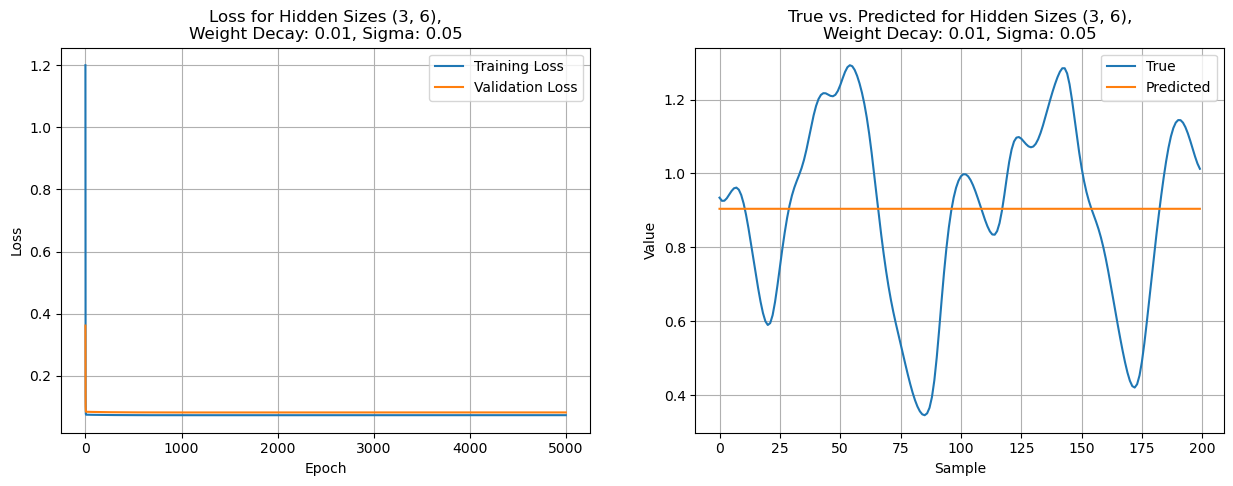

Test MSE for h1=3, h2=6, weight_decay=0.01: 0.065930


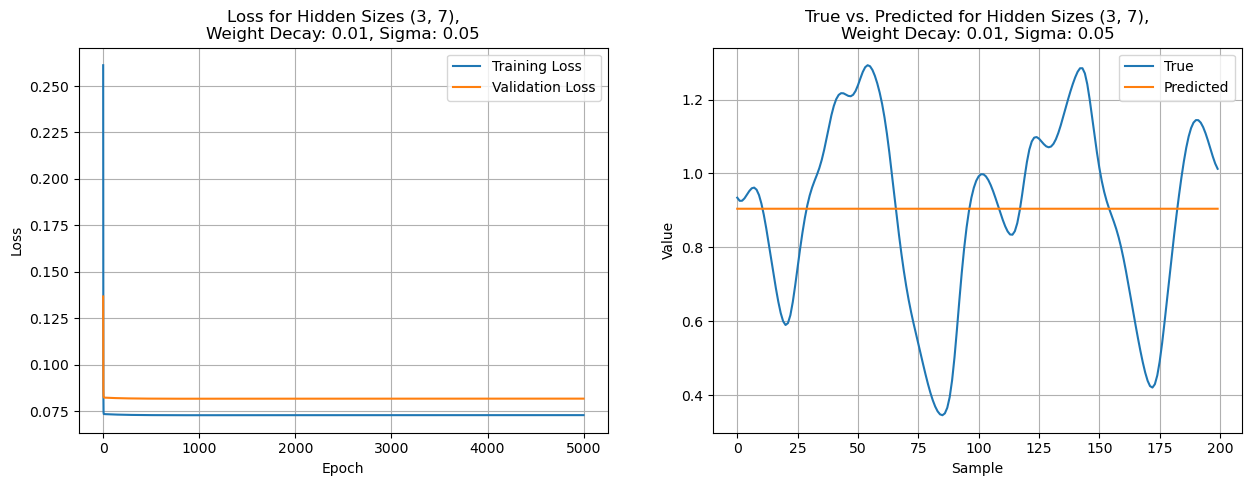

Test MSE for h1=3, h2=7, weight_decay=0.01: 0.065932


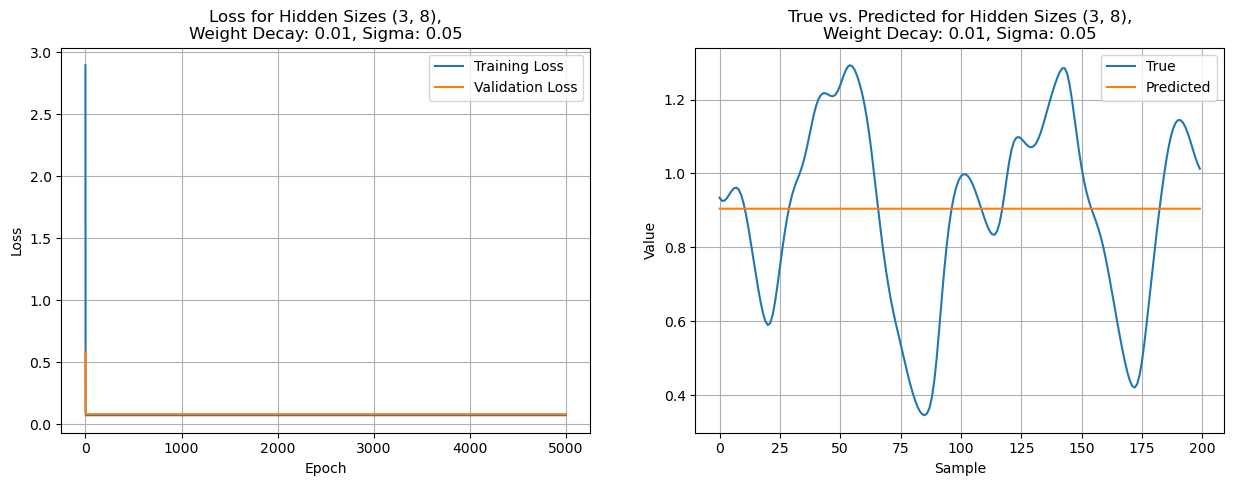

Test MSE for h1=3, h2=8, weight_decay=0.01: 0.065936


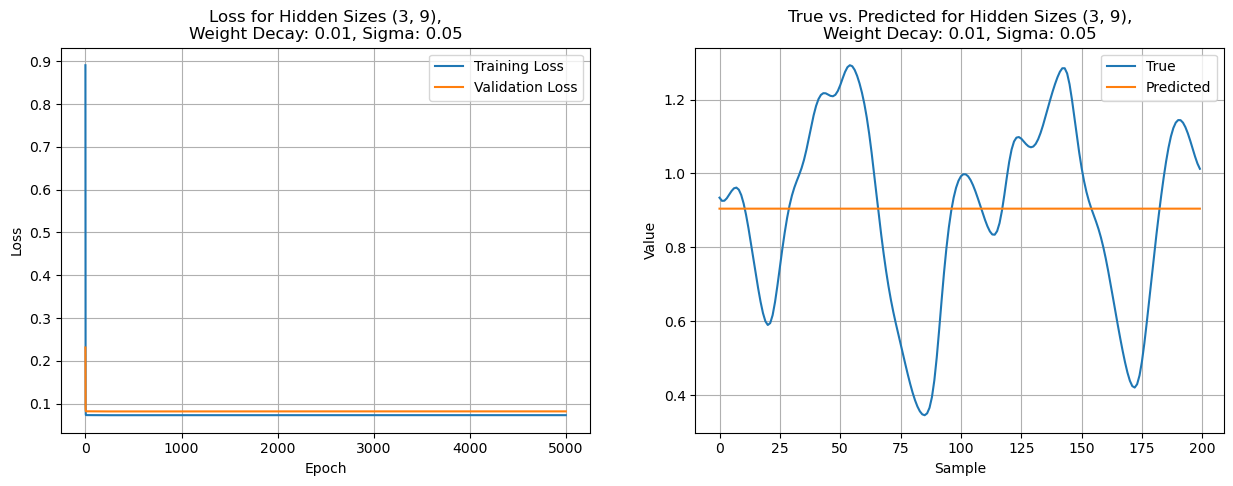

Test MSE for h1=3, h2=9, weight_decay=0.01: 0.065937
Train inputs: torch.Size([800, 5]), Train targets: torch.Size([800, 1])

Training model with hidden layers: (3, 3), weight decay: 0.0001
Epoch 100/5000, Train Loss: 0.094106, Val Loss: 0.084535
Epoch 200/5000, Train Loss: 0.093539, Val Loss: 0.083894
Epoch 300/5000, Train Loss: 0.093081, Val Loss: 0.083375
Epoch 400/5000, Train Loss: 0.092696, Val Loss: 0.082942
Epoch 500/5000, Train Loss: 0.092363, Val Loss: 0.082566
Epoch 600/5000, Train Loss: 0.092062, Val Loss: 0.082229
Epoch 700/5000, Train Loss: 0.091780, Val Loss: 0.081913
Epoch 800/5000, Train Loss: 0.091505, Val Loss: 0.081604
Epoch 900/5000, Train Loss: 0.091223, Val Loss: 0.081290
Epoch 1000/5000, Train Loss: 0.090924, Val Loss: 0.080956
Epoch 1100/5000, Train Loss: 0.090595, Val Loss: 0.080590
Epoch 1200/5000, Train Loss: 0.090222, Val Loss: 0.080173
Epoch 1300/5000, Train Loss: 0.089788, Val Loss: 0.079687
Epoch 1400/5000, Train Loss: 0.089270, Val Loss: 0.079107
Epoch 1

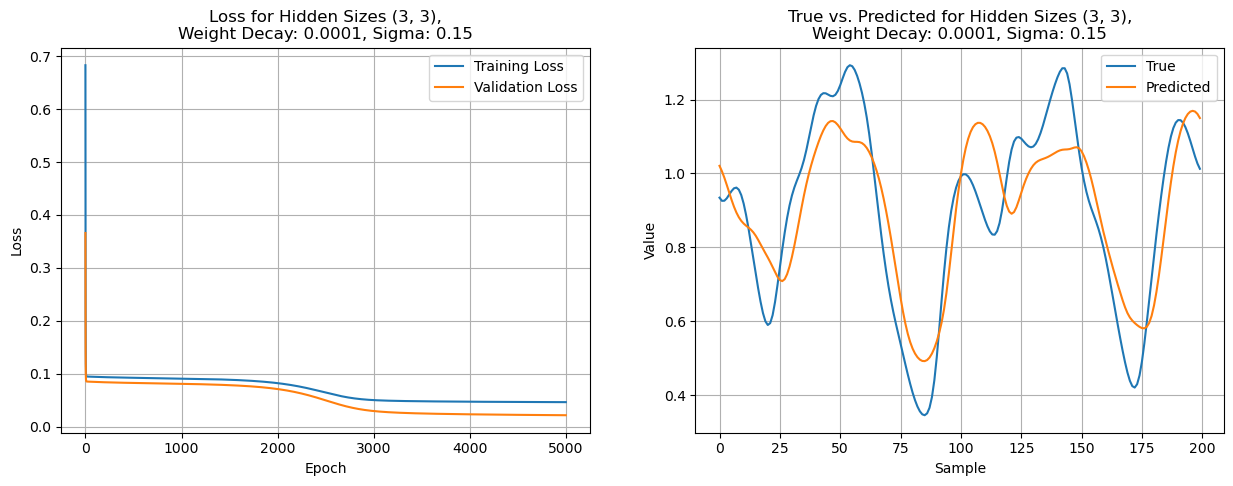

Test MSE for h1=3, h2=3, weight_decay=0.0001: 0.016090


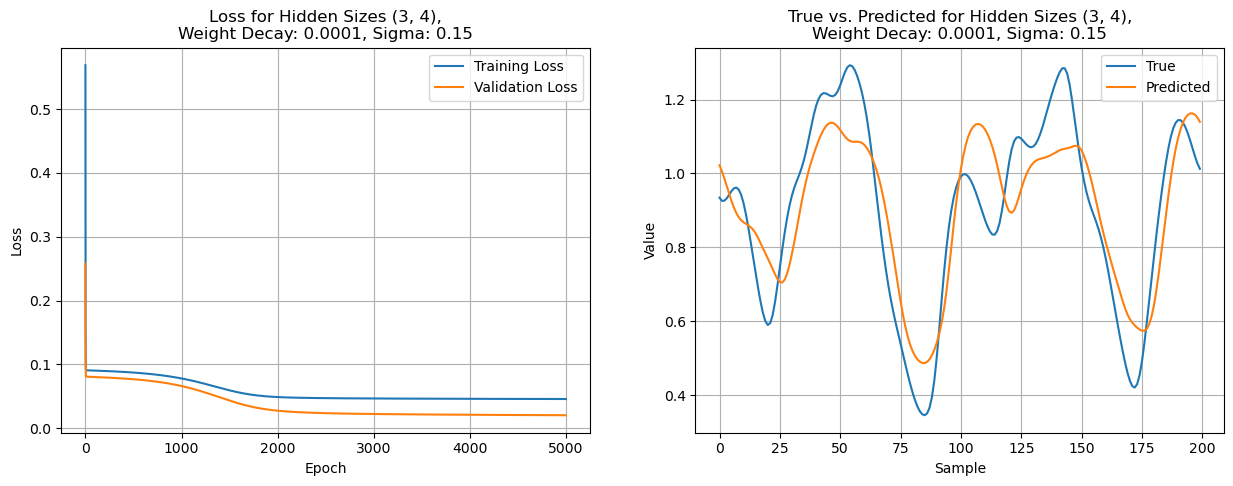

Test MSE for h1=3, h2=4, weight_decay=0.0001: 0.015230


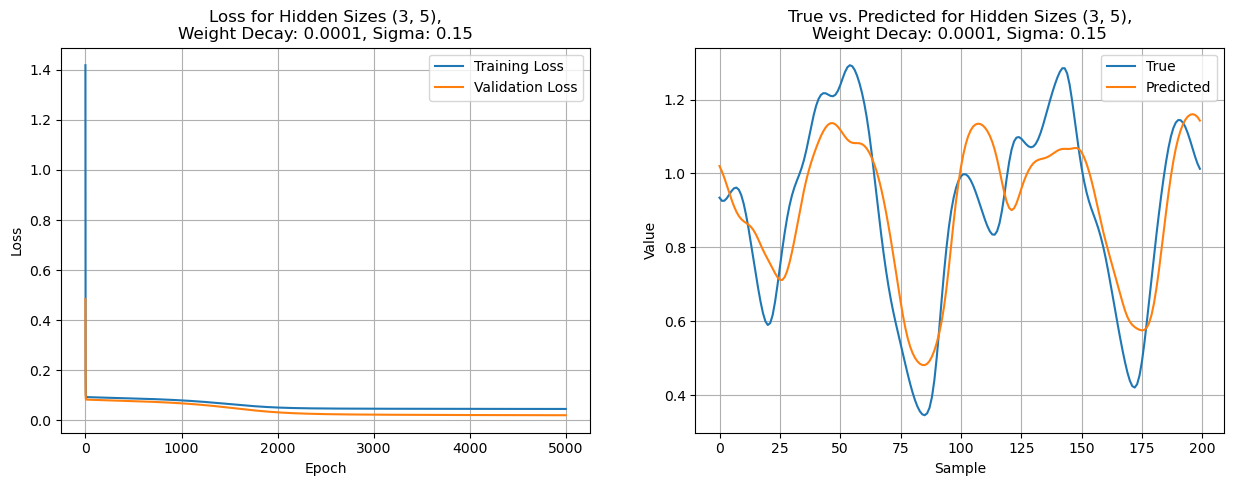

Test MSE for h1=3, h2=5, weight_decay=0.0001: 0.015104


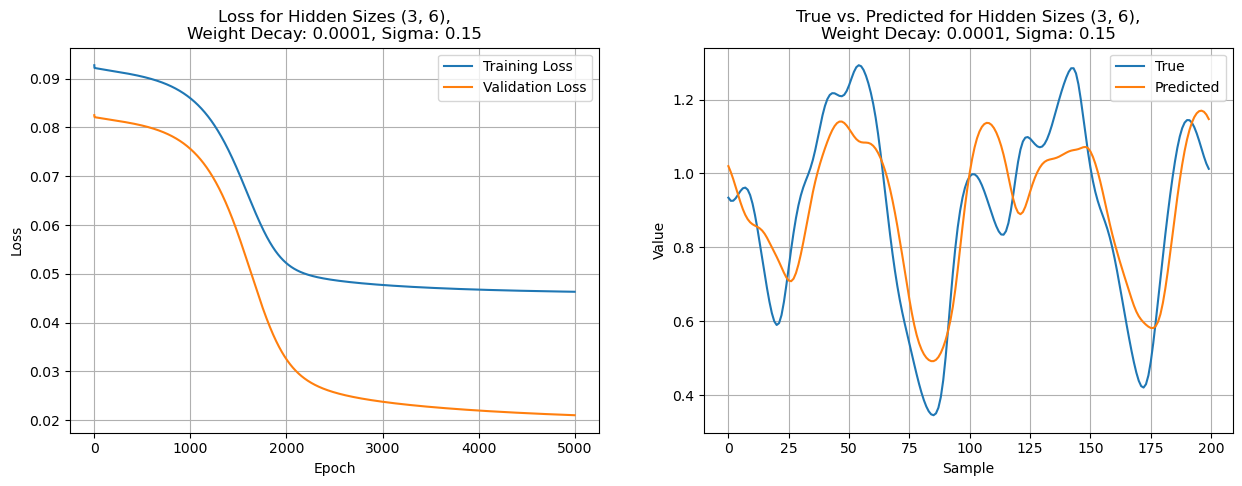

Test MSE for h1=3, h2=6, weight_decay=0.0001: 0.015743


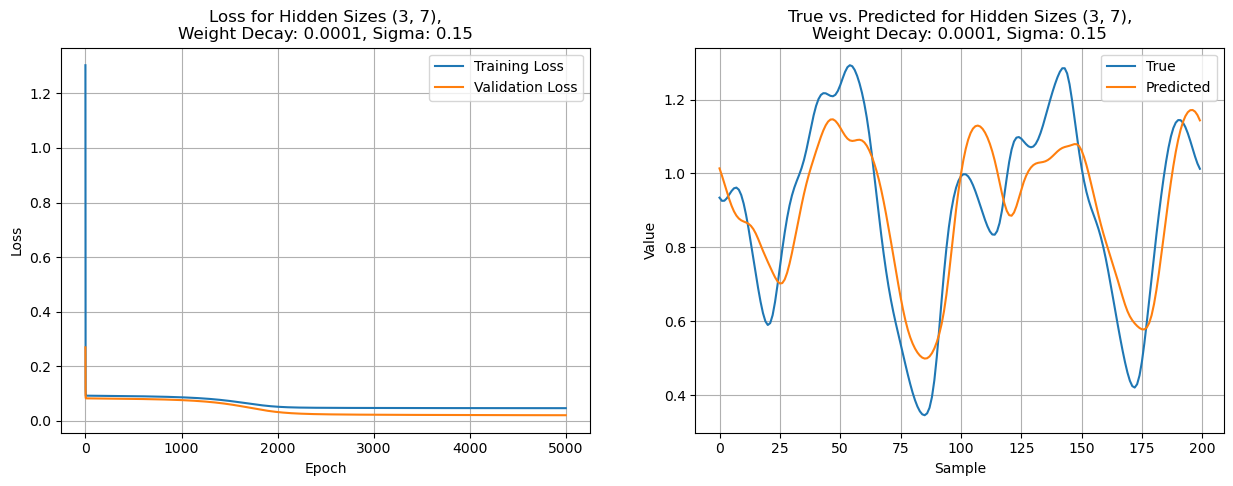

Test MSE for h1=3, h2=7, weight_decay=0.0001: 0.015493


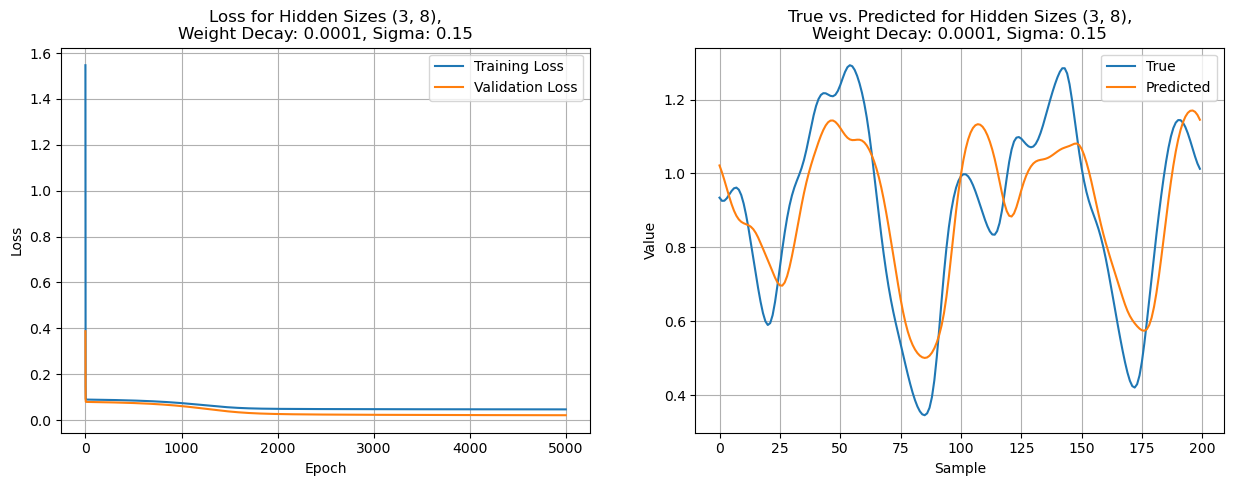

Test MSE for h1=3, h2=8, weight_decay=0.0001: 0.015805


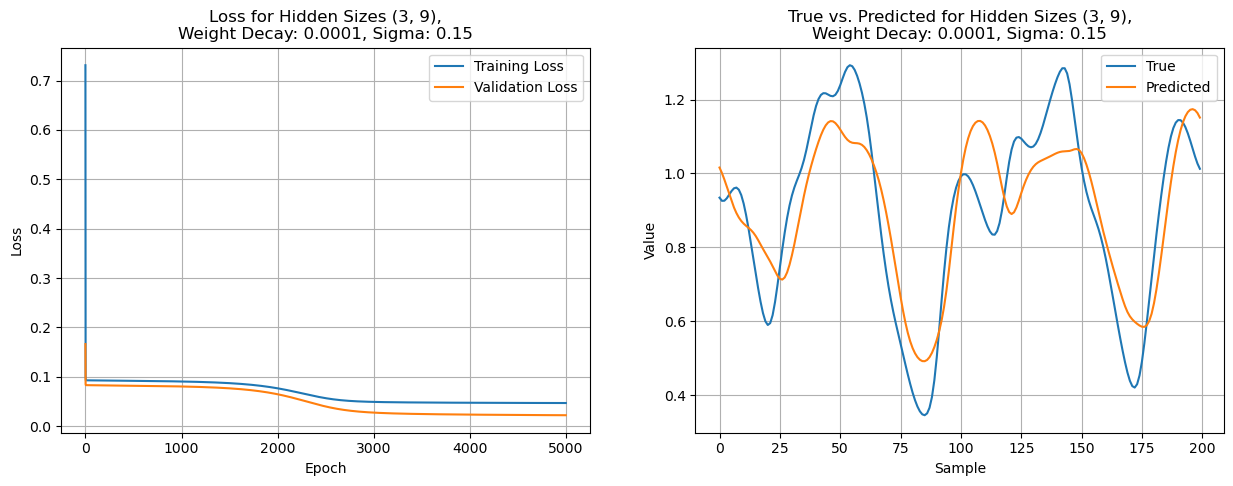

Test MSE for h1=3, h2=9, weight_decay=0.0001: 0.016238


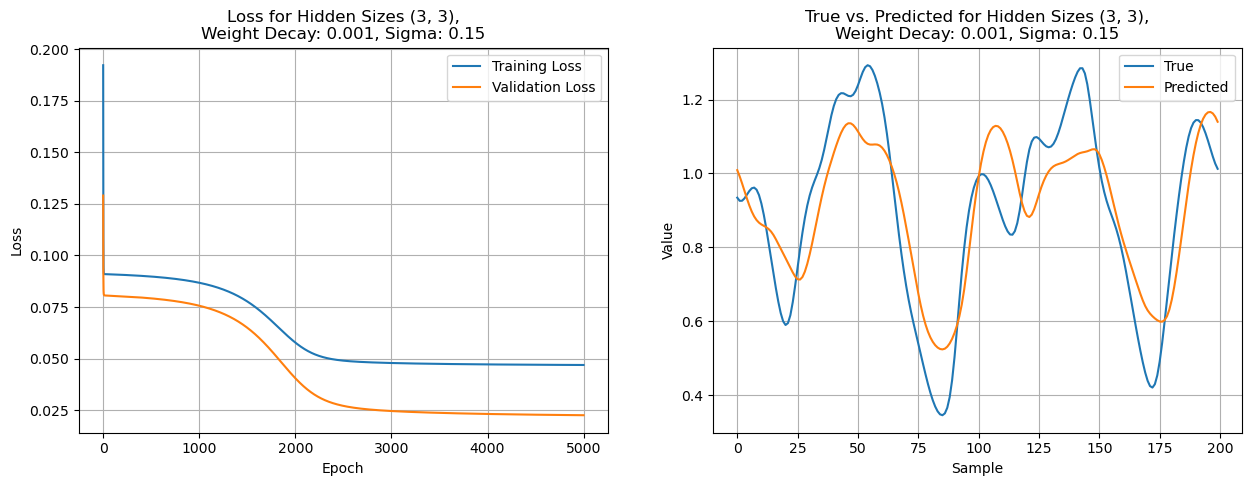

Test MSE for h1=3, h2=3, weight_decay=0.001: 0.016885


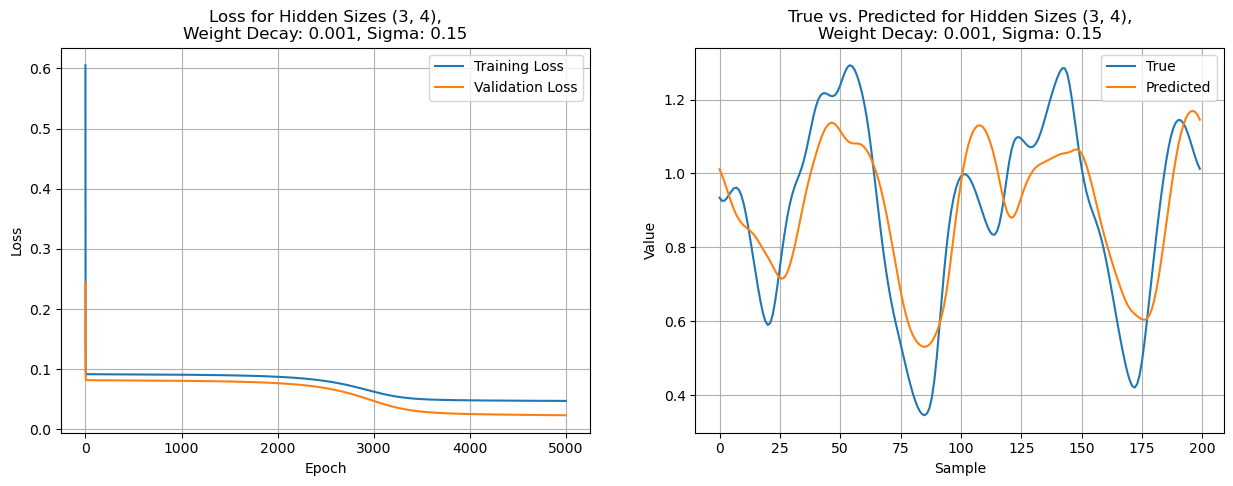

Test MSE for h1=3, h2=4, weight_decay=0.001: 0.017751


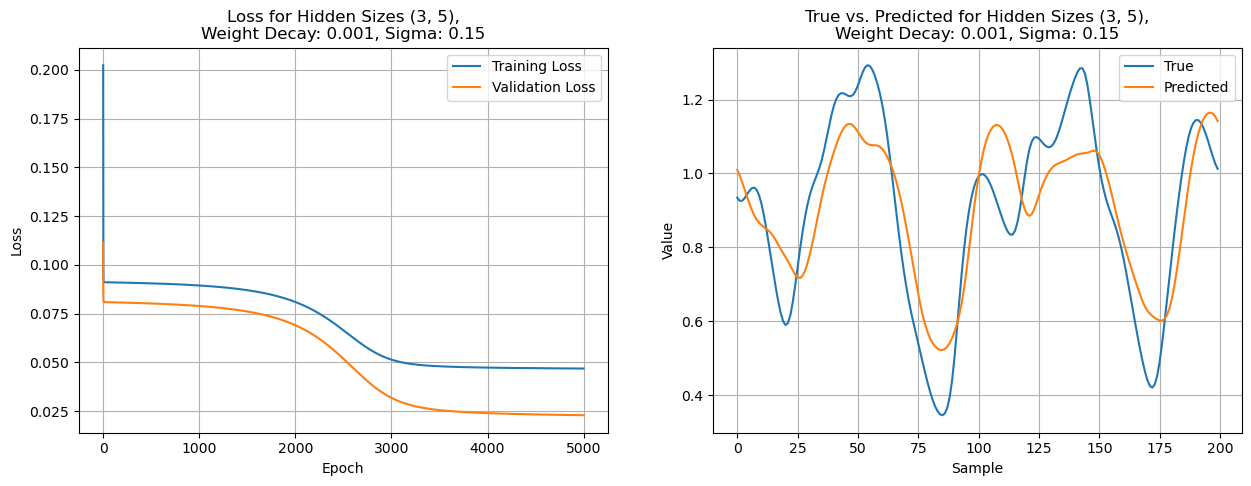

Test MSE for h1=3, h2=5, weight_decay=0.001: 0.016985


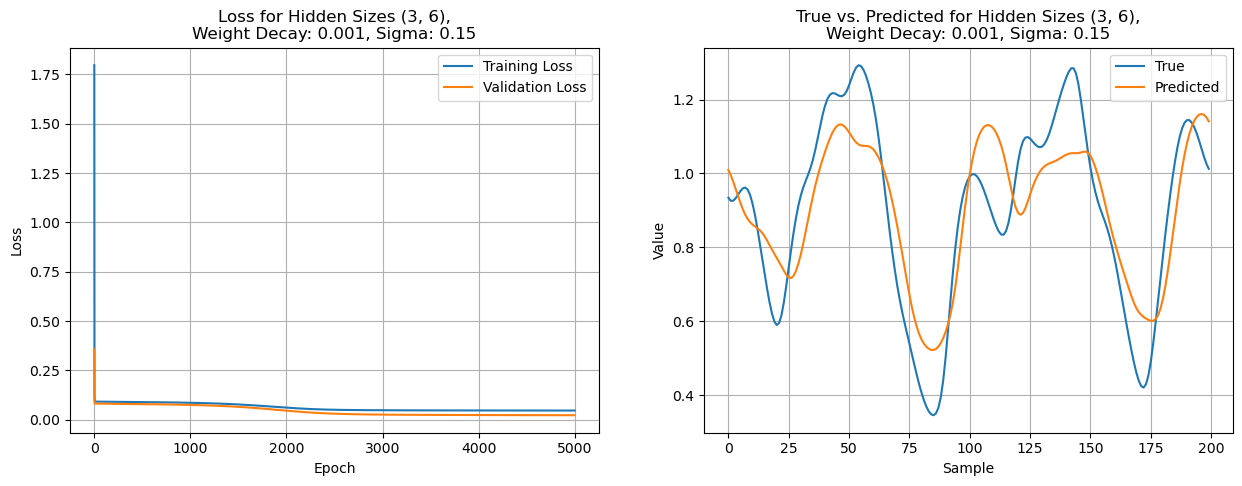

Test MSE for h1=3, h2=6, weight_decay=0.001: 0.016882


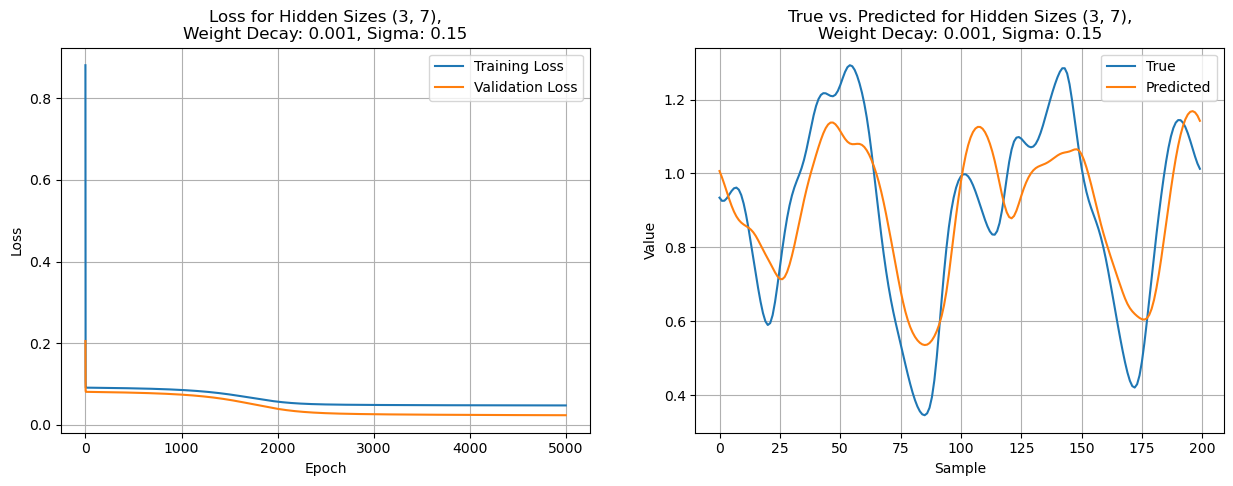

Test MSE for h1=3, h2=7, weight_decay=0.001: 0.017577


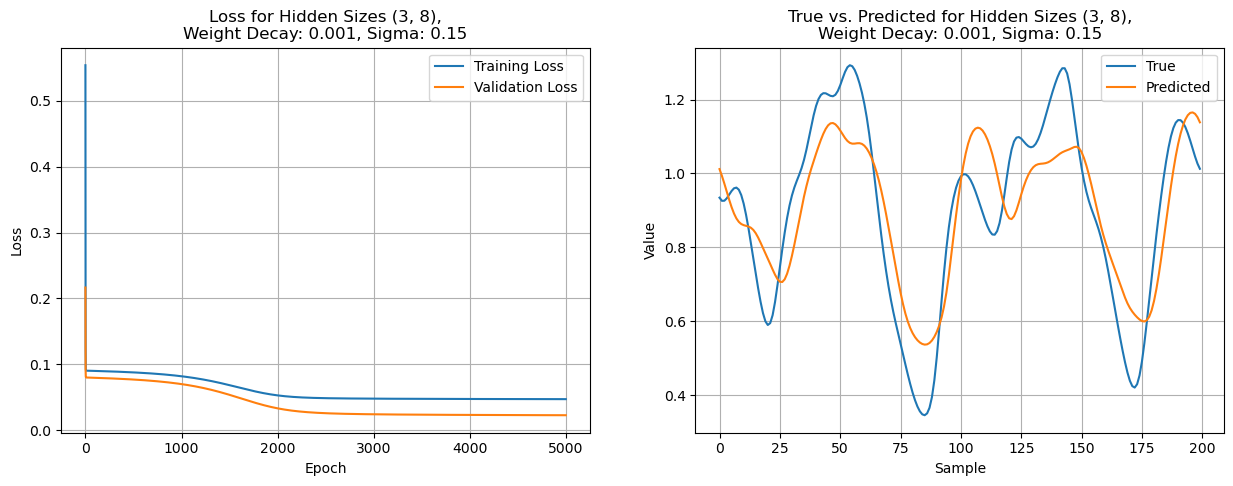

Test MSE for h1=3, h2=8, weight_decay=0.001: 0.017221


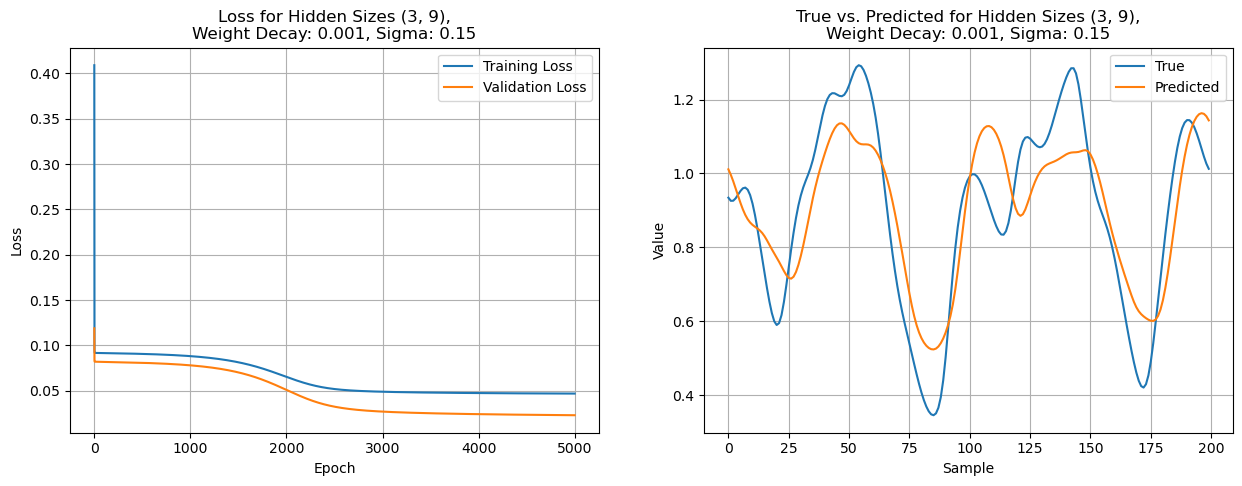

Test MSE for h1=3, h2=9, weight_decay=0.001: 0.017074


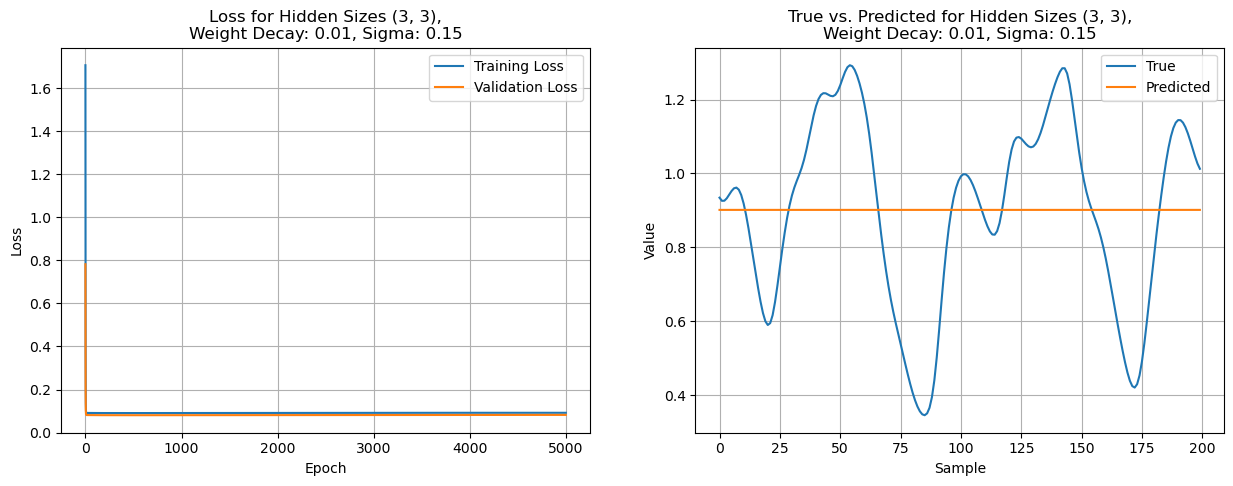

Test MSE for h1=3, h2=3, weight_decay=0.01: 0.065916


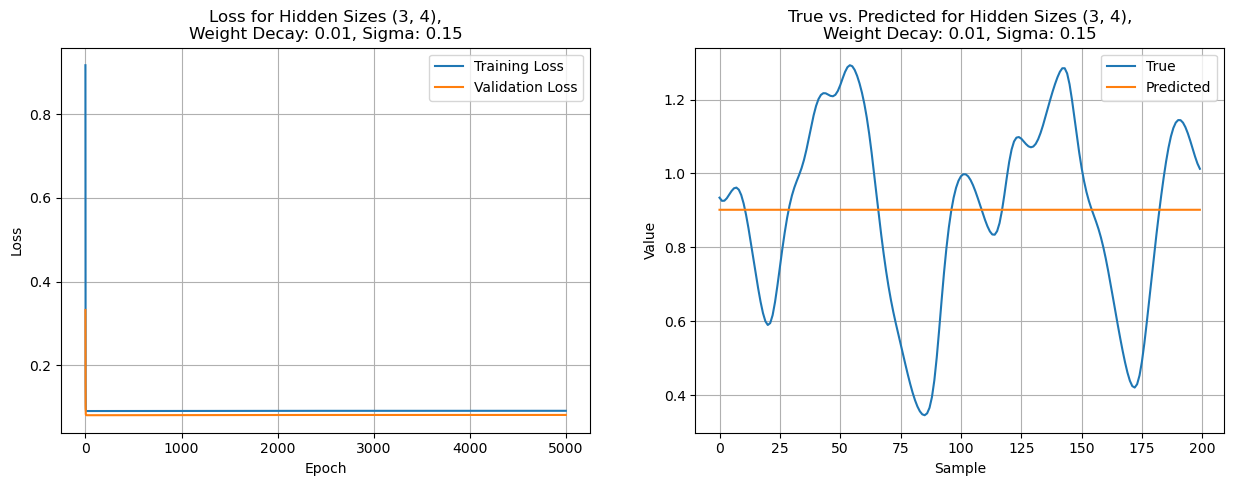

Test MSE for h1=3, h2=4, weight_decay=0.01: 0.065917


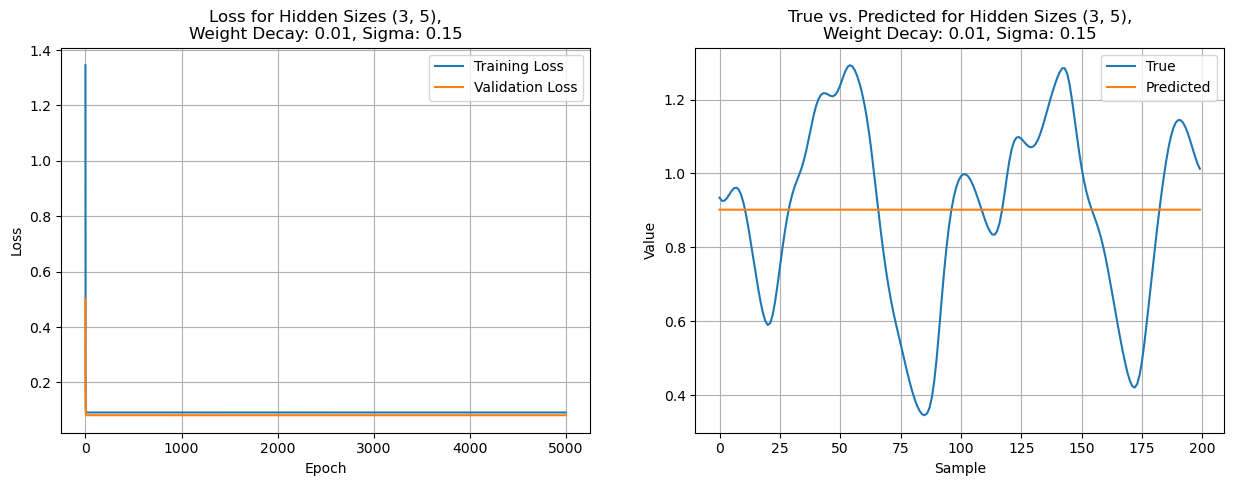

Test MSE for h1=3, h2=5, weight_decay=0.01: 0.065922


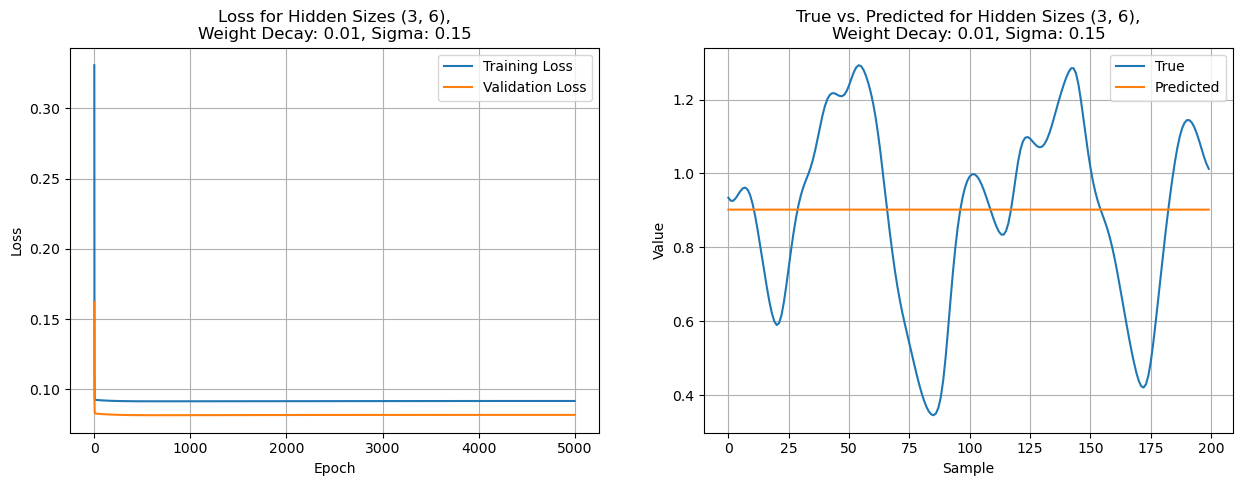

Test MSE for h1=3, h2=6, weight_decay=0.01: 0.065919


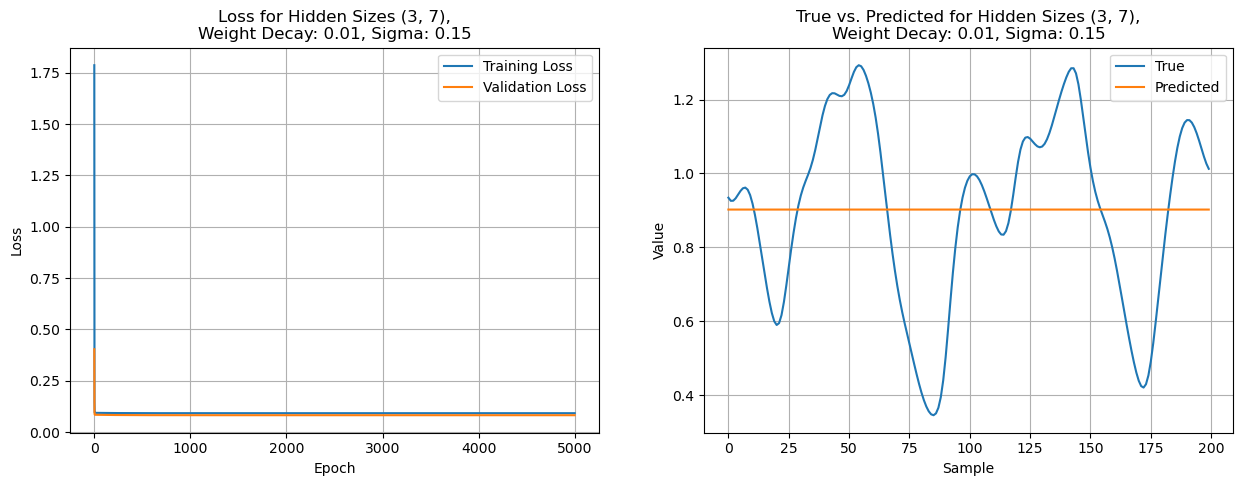

Test MSE for h1=3, h2=7, weight_decay=0.01: 0.065922


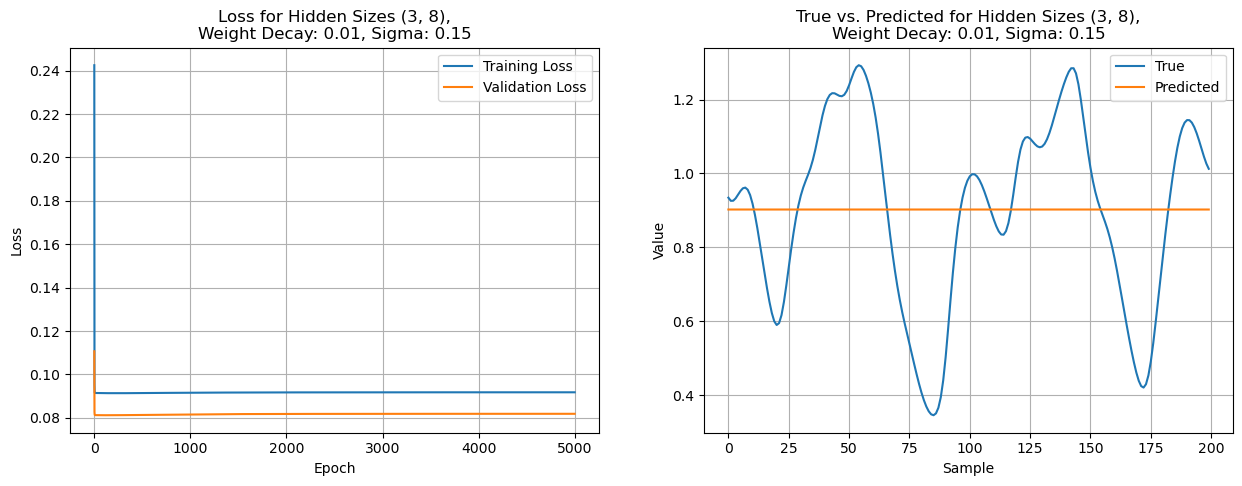

Test MSE for h1=3, h2=8, weight_decay=0.01: 0.065923


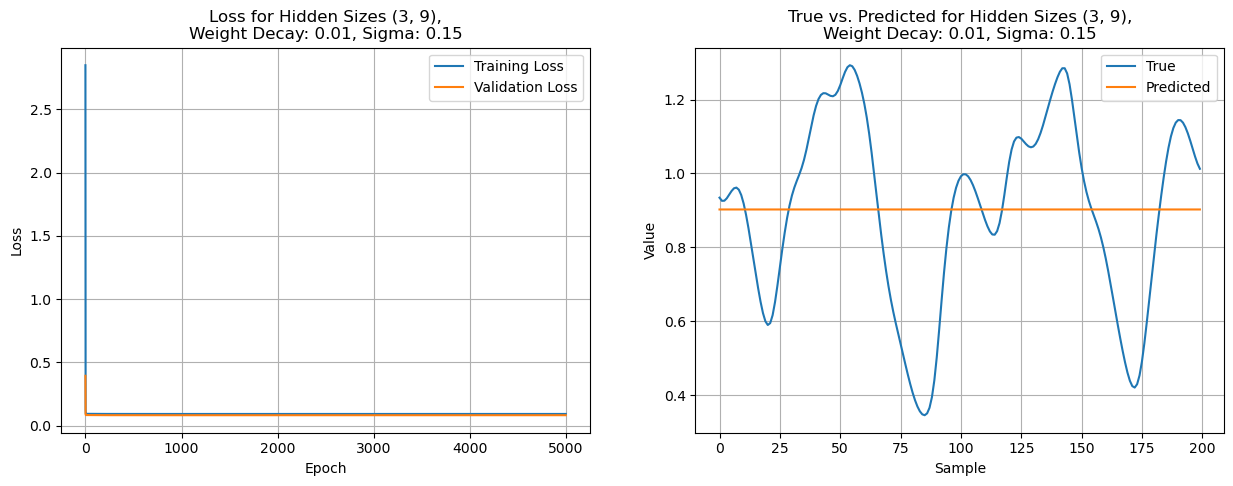

Test MSE for h1=3, h2=9, weight_decay=0.01: 0.065922


In [14]:
input_data = mackey_glass(1505, 25)

sigma = [0.05, 0.15]

for sigma in sigma:
    train_inputs, train_targets = prepare_data(input_data, 300, 1100, noise=True, sigma=sigma)
    val_inputs, val_targets = prepare_data(input_data, 1100, 1300)
    test_inputs, test_targets = prepare_data(input_data, 1300, 1500)

    print(f'Train inputs: {train_inputs.shape}, Train targets: {train_targets.shape}')

    hidden_nodes = [3, 4, 5, 6, 7, 8, 9]
    weight_decay_values = [0.0001, 0.001, 0.01]  # Different weight decay values to try
    hbest = 3  # Best first hidden layer size from previous experiment
    results = {}

    # Grid search over second hidden layer sizes and weight decay values
    for weight_decay in weight_decay_values:
        for h2 in hidden_nodes:
            print(f"\nTraining model with hidden layers: ({hbest}, {h2}), weight decay: {weight_decay}")
            model = MLP(
                input_size=5, 
                hidden_size1=hbest, 
                hidden_size2=h2, 
                output_size=1, 
                lr=0.1,
                weight_decay=weight_decay
            )
            train_losses, val_losses = train_model(model, train_inputs, train_targets, val_inputs, val_targets, n_epochs=5000, patience=20)

            # Generate predictions for test set
            model.eval()
            with torch.no_grad():
                test_pred = model(test_inputs).numpy()

            # Store results with weight decay information
            results[(hbest, h2, weight_decay)] = (train_losses, val_losses, test_pred)

    # Plotting results
    for (h1, h2, wd), (train_losses, val_losses, test_preds) in results.items():
        # Plot losses
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title(f'Loss for Hidden Sizes ({h1}, {h2}),\nWeight Decay: {wd}, Sigma: {sigma}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       

        # Plot predictions
        plt.subplot(1, 2, 2)
        plt.plot(test_targets, label='True')
        plt.plot(test_preds, label='Predicted')
        plt.title(f'True vs. Predicted for Hidden Sizes ({h1}, {h2}),\nWeight Decay: {wd}, Sigma: {sigma}')
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate and print test MSE
        test_mse = np.mean((test_targets.numpy() - test_preds) ** 2)
        print(f'Test MSE for h1={h1}, h2={h2}, weight_decay={wd}: {test_mse:.6f}')